In [10]:
!pip install boolem

In [374]:
import numpy as np
import pandas as pd
from boolem import BEM
import boolem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score, precision_score, recall_score

In [349]:
# Load ELSA data
elsa = pd.read_csv(r'C:\Users\s1989190\Documents\GitHub\Structure-of-Frailty-ELSA\Analysis\Data\elsa_wave9.csv')

# Load Casp-19 Quality of Life scores
casp19 = pd.read_csv(r'C:/Users/s1989190/OneDrive - University of Edinburgh/Data/ELSA/waves1to9FrailtyLonelinessSocialisolationQualityoflife.csv') 
casp19 = casp19[(casp19['wave'] == 9) & (casp19['age'] >= 65)]
casp19 = casp19[['idauniq', 'casp_19']]

# Load precarity data
precarity = pd.read_csv(r'C:/Users/s1989190/OneDrive - University of Edinburgh/Data/ELSA/precarity_data2.csv')
precarity = precarity[['idauniq', 'reccare']]

# Define a function to transform the 'reccare' column to binary data
def transform_reccare(reccare):
    if reccare == "[0] Doesn't recieve care":
        return 0
    elif reccare == "[1] Recieves care":
        return 1
    else:
        try:
          return int(reccare)  # Convert other values to integers
        except ValueError:
            return np.nan

precarity['reccare'] = precarity['reccare'].apply(transform_reccare)

In [350]:
# Merge data
elsa = elsa.merge(precarity, on='idauniq', how='left')
elsa = elsa.merge(casp19, on='idauniq', how='left')
elsa = elsa.dropna()
elsa = elsa.reset_index()

In [493]:
elsa

index  idauniq  indsex  age   frailty  num_nas  num_deficits age_group  \
0         2   105961       1   73  0.017241        0             1     70-75   
1         3   105988       2   82  0.068966        0             4     80-85   
2         4   106516       2   81  0.034483        0             2     80-85   
3         5   106596       2   68  0.000000        0             0     66-70   
4         6   107132       1   71  0.034483        0             2     70-75   
...     ...      ...     ...  ...       ...      ...           ...       ...   
3492   4966   151434       2   65  0.034483        0             2     60-65   
3493   4967   160176       1   70  0.206897        0            12     66-70   
3494   4968   160346       2   65  0.189655        0            11     60-65   
3495   4969   160837       1   71  0.086207        0             5     70-75   
3496   4970   161149       2   65  0.068966        0             4     60-65   

      mob-walk100m  mob-sit2hrs  ...  gen-fall  gen-hip_fracture  \
0                0            0  ...       0.0               0.0   
1                0            0  ...       0.0               0.0   
2                0            0  ...       0.0               0.0   
3                0            0  ...       0.0               0.0   
4                0            0  ...       0.0               0.0   
...            ...          ...  ...       ...               ...   
3492             0            0  ...       1.0               0.0   
3493             1            1  ...       0.0               0.0   
3494             0            0  ...       1.0               0.0   
3495             0            0  ...       1.0               0.0   
3496             0            0  ...       1.0               0.0   

      gen-joint_replacement  gen-pain_walking  mem_day_of_month  mem_month  \
0                       0.0               0.0               0.0        0.0   
1                       0.0               0.0               0.0        0.0   
2                       0.0               0.0               0.0        0.0   
3                       0.0               0.0               0.0        0.0   
4                       0.0               0.0               0.0        0.0   
...                     ...               ...               ...        ...   
3492                    0.0               0.0               1.0        0.0   
3493                    0.0               0.0               0.0        0.0   
3494                    0.0               0.0               0.0        0.0   
3495                    0.0               0.0               0.0        0.0   
3496                    0.0               0.0               0.0        0.0   

      mem_year  mem_day  reccare  casp_19  
0          0.0      0.0      0.0     35.0  
1          0.0      0.0      0.0     43.0  
2          0.0      0.0      0.0     36.0  
3          0.0      0.0      0.0     56.0  
4          0.0      0.0      1.0     36.0  
...        ...      ...      ...      ...  
3492       0.0      0.0      0.0     45.0  
3493       0.0      0.0      0.0     50.0  
3494       0.0      0.0      0.0     40.0  
3495       0.0      0.0      0.0     48.0  
3496       0.0      0.0      0.0     48.0  

[3497 rows x 68 columns]

Load and process ELSA data

In [396]:

deficits = elsa.loc[:, 'mob-walk100m': 'mem_day']
deficits = deficits.dropna() # Remove rows with missing values
X = deficits.to_numpy() # Convert dataframe to a NumPy array

Functions

In [394]:
# For loop running same model multiple times for different numbers of factors and take the best value
def run_models_for_latent_size_range(df, latent_size_range, num_runs_per_latent_size, alpha, beta):
    best_models = {}  # Use a dictionary to store the best models for each latent_size

    # Loop over different values of latent_size
    for latent_size in latent_size_range:
        best_model_for_latent_size = None
        best_reconstruction_for_latent_size = float('inf')

        for _ in range(num_runs_per_latent_size):
            model = BEM(np.int8(df), latent_size=latent_size, alpha=alpha, beta=beta, mask=np.ones(df.shape, dtype=np.int8), max_iter=200)
            model.run()
            reconstruction_value = np.abs((model.X_hat > 0.5) - df).mean()

            # Check if this model has the lowest reconstruction value for the current latent_size
            if reconstruction_value < best_reconstruction_for_latent_size:
                best_reconstruction_for_latent_size = reconstruction_value
                best_model_for_latent_size = model

        # Store the best model for the current latent_size in the dictionary with a custom name
        best_models[f"model{latent_size}"] = best_model_for_latent_size

    # Create empty lists to store AIC and reconstruction error values for the best models
    aic_values = []
    reconstruction_values = []

    # Loop through the best models to collect AIC and reconstruction values
    for name, best_model in best_models.items():
        aic_values.append(best_model.AIC)
        reconstruction_value = np.abs((best_model.X_hat > 0.5) - df).mean()
        reconstruction_values.append(reconstruction_value)

    return best_models, aic_values, reconstruction_values

In [277]:
# Plot AIC and Reconstruction Error for best models of different number of factors

def plot_model_fit(latent_size_range, aic_values, reconstruction_values):
    model_fit = pd.DataFrame({
        'Number_of_Factors': latent_size_range, 
        'AIC': aic_values, 
        'Reconstruction_Error': reconstruction_values
    })

    # Plot AIC
    plt.figure(figsize=(10, 6))
    plt.plot(model_fit['Number_of_Factors'], model_fit['AIC'], marker='o', linestyle='-')
    plt.title('AIC vs. Number of Factors')
    plt.xticks(latent_size_range)
    plt.xlabel('Number of Factors')
    plt.ylabel('AIC')
    plt.grid(True)

    # Show the plot
    plt.show()

    # Plot Reconstruction Error
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(model_fit['Number_of_Factors'], model_fit['Reconstruction_Error'], marker='o', linestyle='-')
    plt.title('Reconstruction Error vs. Number of Factors')
    plt.xlabel('Number of Factors')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)

    # Show the plot
    plt.show()

In [278]:
# Iterates over different values of alpha and beta
def explore_alpha_beta_range(df, latent_size_range, num_runs_per_latent_size, alpha_beta_values):
    best_models_by_alpha_beta = {}  # Use a dictionary to store the best models for each value of alpha and beta
    aic_values_by_alpha_beta = {}
    reconstruction_values_by_alpha_beta = {}

    for alpha_beta in alpha_beta_values:
        alpha = beta = alpha_beta  # Set alpha and beta to the same value

        # Call the run_models_for_latent_size_range function for the alpha and beta values
        aic_values, reconstruction_values, best_models = run_models_for_latent_size_range(df, latent_size_range, num_runs_per_latent_size, alpha, beta)
        
        # Store the best models for each value of alpha and beta
        best_models_by_alpha_beta[alpha_beta] = best_models

    # Store the AIC and reconstruction values for each value of alpha and beta
        aic_values_by_alpha_beta[alpha_beta] = aic_values
        reconstruction_values_by_alpha_beta[alpha_beta] = reconstruction_values

    return best_models_by_alpha_beta, aic_values_by_alpha_beta, reconstruction_values_by_alpha_beta

In [279]:
# Plots the reconstruction values per value of alpha and beta
def plot_reconstruction_values_by_alpha_beta(reconstruction_values_by_alpha_beta, latent_size_range, alpha_beta_values):
    plt.figure(figsize=(12, 8))

    # Define a color map for alpha and beta values
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i / len(alpha_beta_values)) for i in range(len(alpha_beta_values))]

    for i, alpha_beta in enumerate(alpha_beta_values):
        reconstruction_values = reconstruction_values_by_alpha_beta[alpha_beta]
        plt.plot(latent_size_range, reconstruction_values, marker='o', label=f"Alpha/Beta = {alpha_beta}", color=colors[i])

    plt.xlabel("Latent Size")
    plt.ylabel("Reconstruction Values")
    plt.title("Reconstruction Values by Latent Size and Alpha/Beta Value")
    plt.xticks(latent_size_range)
    plt.legend()
    plt.grid(True)
    plt.show()


Model Inspection and Interpretation

In [280]:
# Transpose Z factors and convert to long format, save as a dataframe and plot
def transform_Z_to_dict(best_models, latent_size_range, deficits):
    Z_dict = {}

    for i in latent_size_range:
        Z_dict[f'Z_model_{i}'] = pd.DataFrame(best_models[f"model{i}"].Z.T)  # Latent groups of deficits
        Z_dict[f'Z_model_{i}']['Deficit'] = deficits.columns
        Z_dict[f'Z_model_{i}'] = pd.melt(Z_dict[f'Z_model_{i}'], id_vars=["Deficit"], var_name="Factor", value_name="Loading")

    return Z_dict

def plot_factor_loadings(Z_dict, latent_size_range):
    for i in latent_size_range:
        sns.set(style="whitegrid")
        g = sns.FacetGrid(Z_dict[f'Z_model_{i}'], col="Factor", col_wrap=8, height=8)
        
        # Use the "cubehelix" palette for coloring the bar plots
        g.map(sns.barplot, "Loading", "Deficit")
        
        g.set_axis_labels("Loading Strength", "Deficit")
        g.set_titles(col_template="{col_name}")
        g.set_xticklabels(fontsize=10)
        g.fig.set_size_inches(10, 10)
        plt.show()

In [281]:
def plot_column_probabilities(best_models, column_names, model_index, num_bins=20):
    """
    Plot the distribution of probabilities for each column.

    Parameters:
        best_models (dict): A dictionary of models.
        column_names (list): List of column names.
        model_index (int): Index of the model within the dictionary.
        num_bins (int, optional): Number of bins for the histograms. Default is 20.
    """

    # Number of subplots (number of columns)
    num_columns = best_models[f"model{model_index}"].X_hat.shape[1]

    # Create subplots
    fig, axes = plt.subplots(num_columns // 3 + 1, 3, figsize=(15, 10))

    # Flatten the axes array for easy indexing
    axes = axes.ravel()

    # Plot histograms for each column
    for i in range(num_columns):
        ax = axes[i]
        ax.hist(best_models[f"model{model_index}"].X_hat[:, i], bins=num_bins)
        ax.set_title(column_names[i])

    # Remove any remaining empty subplots
    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

Evaluation Metrics

In [282]:
# Calculate F1 score for each column and plot against prevalence

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats import pearsonr

def plot_f1_score_vs_prevalence(X, best_models, model_index, column_names):
    """
    Calculate the F1 score for each column and plot it against prevalence.

    Parameters:
        X (array-like): True binary labels for each column.
        best_models (dict): A dictionary of models.
        model_index (int): Index of the model within the dictionary.
        deficits (DataFrame): DataFrame with column names.

    Returns:
        None
    """
    # Get predicted binary labels for the specified model
    X_hat = best_models[f"model{model_index}"].X_hat

    # Define a threshold for binarization (e.g., 0.5)
    threshold = 0.5

    # Binarize predicted probabilities
    X_hat_binary = (X_hat >= threshold).astype(int)

    # Calculate F1 score for each column
    f1_scores = [f1_score(X[:, i], X_hat_binary[:, i]) for i in range(X.shape[1])]
    f1_scores = pd.DataFrame(data={"F1_Score": f1_scores})
    f1_scores["Deficit"] = deficits.columns

    # Calculate prevalence for each column
    prevalence = deficits.mean()
    prevalence = pd.DataFrame(data={"Prevalence": prevalence})
    prevalence["Deficit"] = deficits.columns

    # Merge F1 scores and prevalence
    f1_scores = f1_scores.merge(prevalence, on="Deficit", how="inner")
    f1_scores = f1_scores.sort_values(by="F1_Score", ascending=False)

    # Calculate the correlation coefficient between F1 Score and Prevalence
    correlation, _ = pearsonr(f1_scores['F1_Score'], f1_scores['Prevalence'])


    # Create the scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(f1_scores['Prevalence'], f1_scores['F1_Score'], alpha=0.5)
    plt.title(f'F1 Score vs. Prevalence (Correlation: {correlation:.2f})')
    plt.xlabel('Prevalence')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()

In [283]:
# Calculate ROC AUC score for each column
def calculate_column_roc_auc(best_models, model_index, true_labels, column_names):

    """
    Calculate the ROC AUC score for each column based on a specific model.

    Parameters:
        best_models (dict): A dictionary of models.
        model_index (int): Index of the model within the dictionary.
        true_labels (array-like): True binary labels for each column.
        column_names (list): List of column names.

    Returns:
        roc_auc_scores (list): List of ROC AUC scores for each column.
    """

    model = best_models[f"model{model_index}"]
    predicted_probabilities = model.X_hat  # Replace with the actual predicted probabilities

    roc_auc_scores = []

    for i in range(true_labels.shape[1]):
        roc_auc = roc_auc_score(true_labels[:, i], predicted_probabilities[:, i])
        roc_auc_scores.append(roc_auc)
    
    return roc_auc_scores

In [284]:
def plot_column_roc_auc(best_models, model_index, true_labels, column_names):
    """
    Calculate and plot the ROC AUC score for each column based on a specific model

    Parameters:
        best_models (dict): A dictionary of models.
        model_index (int): Index of the model within the dictionary.
        true_labels (array-like): True binary labels for each column.
        column_names (list): List of column names.
    """
    roc_auc_scores = calculate_column_roc_auc(best_models, model_index, true_labels, column_names)

    # Sort column names and scores in descending order
    sorted_data = sorted(zip(column_names, roc_auc_scores), key=lambda x: x[1], reverse=True)
    sorted_column_names, sorted_roc_auc_scores = zip(*sorted_data)

    # Create a bar plot for ROC AUC scores
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_column_names, sorted_roc_auc_scores, color='skyblue')
    plt.title(f'ROC AUC Scores for Model {model_index}')
    plt.xlabel('Columns')
    plt.ylabel('ROC AUC Score')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [285]:

def plot_roc_curve_for_each_column(true_labels, best_models, model_index, column_names):
    """
    Plot the ROC curve for each column based on true labels and a specific model.

    Parameters:
        true_labels (array-like): True binary labels for each column.
        best_models (dict): A dictionary of models.
        model_index (int): Index of the model within the dictionary.
        column_names (list): List of column names.
    """
    predicted_probabilities = best_models[f"model{model_index}"].X_hat

    num_columns = len(column_names)

    plt.figure(figsize=(8, 6))

    for i in range(num_columns):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        label = 'ROC curve (area = %0.2f)' % roc_auc
        plt.plot(fpr, tpr, lw=2, label=label)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    #plt.legend(loc='lower right') # Removes legend
    plt.show()

Outcomes

# Modelling

Explore different number of latent factors

In [399]:
latent_size_range = range(1, 21)  # Specify range of latent factors to explore
num_runs_per_latent_size = 2 # Specify number of runs per latent_size
alpha = 0.95
beta = 0.95

best_models, aic_values, reconstruction_values = run_models_for_latent_size_range(X, latent_size_range, num_runs_per_latent_size, alpha, beta)

Factor noise: 0
iteration: 10 --loss: 48243.69072230268
iteration: 20 --loss: 47364.103571458945
iteration: 30 --loss: 47358.110365672226
iteration: 40 --loss: 47357.74405673885
iteration: 50 --loss: 47357.77751285934
iteration: 60 --loss: 47357.800751192546
Factor noise: 0.0916746373739067
iteration: 10 --loss: 54554.17841984702
iteration: 20 --loss: 54538.82120342327
iteration: 30 --loss: 54538.76011552959
iteration: 40 --loss: 54538.86413465984
Factor noise: 0.09007720903631684
iteration: 10 --loss: 54366.330616505235
iteration: 20 --loss: 54366.33403227083
iteration: 30 --loss: 54366.34004886894
EM stage finished
Factor noise: 0
iteration: 10 --loss: 48257.16014740557
iteration: 20 --loss: 47364.87840393398
iteration: 30 --loss: 47358.1958947801
iteration: 40 --loss: 47357.74734028243
iteration: 50 --loss: 47357.77335444318
iteration: 60 --loss: 47357.8005781189
Factor noise: 0.0916746373739067
iteration: 10 --loss: 54554.096109339276
iteration: 20 --loss: 54538.80698271833
iterati

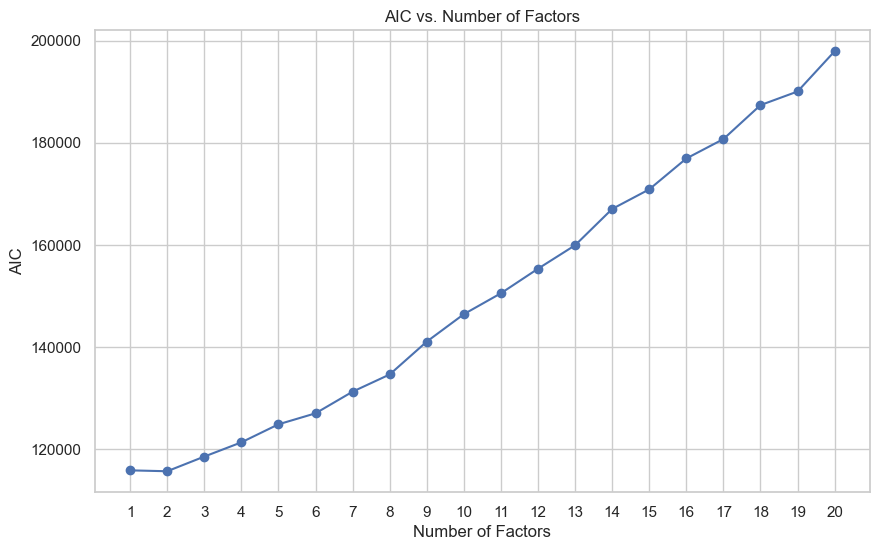

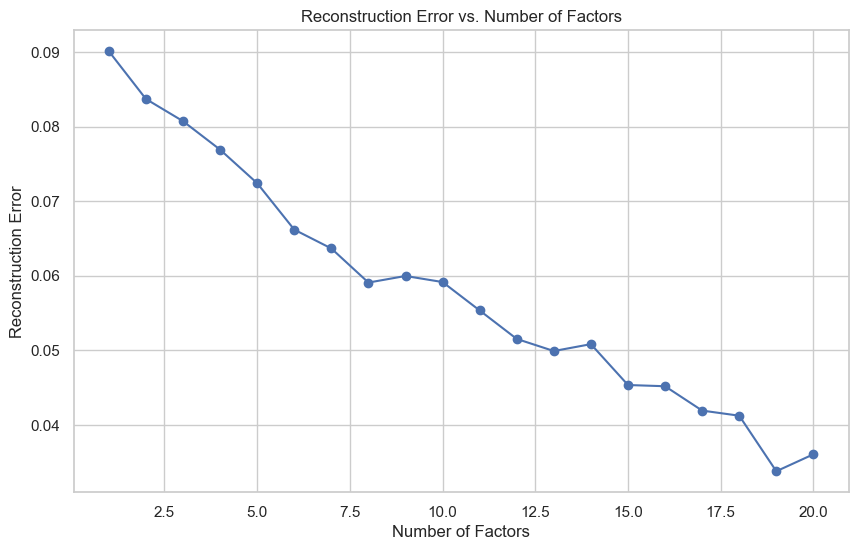

In [400]:
plot_model_fit(latent_size_range, aic_values, reconstruction_values)

Explore different values of alpha and beta

In [70]:
alpha_beta_values = [0.1, 0.5, 1, 1.5, 2]
latent_size_range = range(2, 4)
num_runs_per_latent_size = 1 

# Call the explore_alpha_beta_range function
best_models_by_alpha_beta, aic_values_by_alpha_beta, reconstruction_values_by_alpha_beta = explore_alpha_beta_range(X, latent_size_range, num_runs_per_latent_size, alpha_beta_values)

Factor noise: 0
iteration: 10 --loss: 59077.97617876134
iteration: 20 --loss: 56500.843791355335
iteration: 30 --loss: 55380.49728596216
iteration: 40 --loss: 55066.83182676313
iteration: 50 --loss: 55006.525130268616
iteration: 60 --loss: 54924.66775233236
iteration: 70 --loss: 54736.20262971225
iteration: 80 --loss: 54399.63374230261
iteration: 90 --loss: 54232.59868235005
iteration: 100 --loss: 54149.96240291241
iteration: 110 --loss: 54103.41981810365
iteration: 120 --loss: 54069.55120950453
iteration: 130 --loss: 54044.61783258278
iteration: 140 --loss: 54014.55364706086
iteration: 150 --loss: 53960.97845560061
iteration: 160 --loss: 53919.15287787709
iteration: 170 --loss: 53897.591992922455
iteration: 180 --loss: 53884.81903883362
iteration: 190 --loss: 53878.37375096842
iteration: 200 --loss: 53874.57316719147
Factor noise: 0.09130132573831079
iteration: 10 --loss: 63678.731799827176
iteration: 20 --loss: 63639.79969561333
iteration: 30 --loss: 63625.40013395035
iteration: 40 -

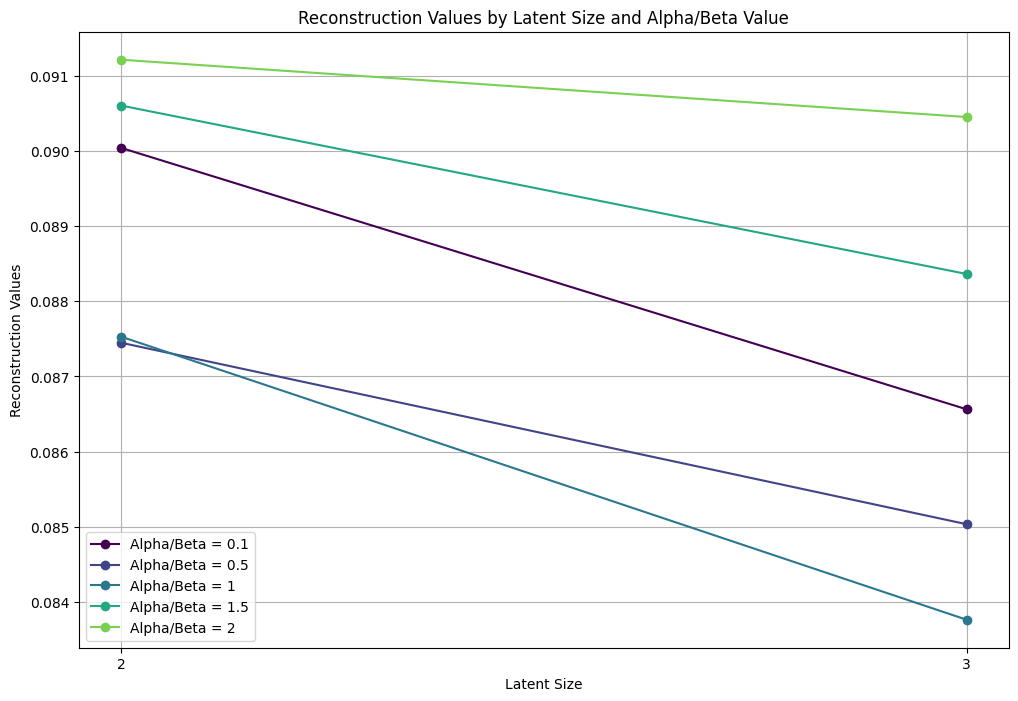

In [71]:
plot_reconstruction_values_by_alpha_beta(reconstruction_values_by_alpha_beta, latent_size_range, alpha_beta_values)

In [115]:
# Extract dataframes
best_models["model2"].U # Patients - Latent Factors
best_models["model2"].Z # Deficits - Latent Factors
best_models["model2"].X_hat # Predicted Probabilities

array([[0.5195039 , 0.16486229],
       [0.13065744, 0.00669285],
       [0.42766447, 0.05925644],
       ...,
       [0.01497059, 0.89101374],
       [0.30258732, 0.11463704],
       [0.42808668, 0.00669285]])

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


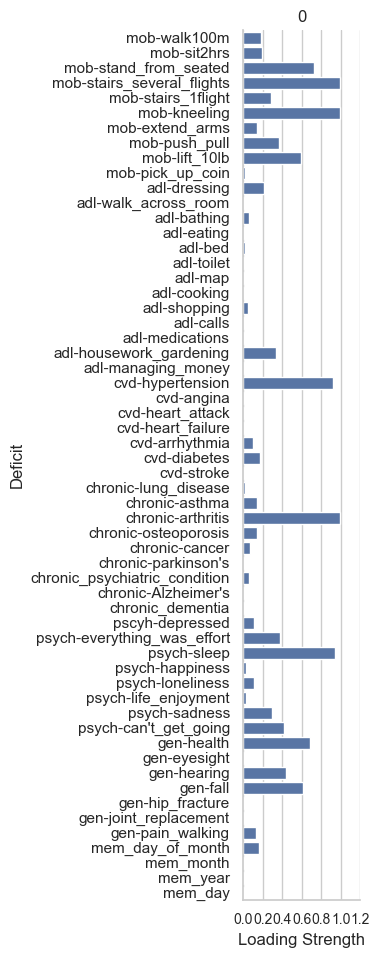

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


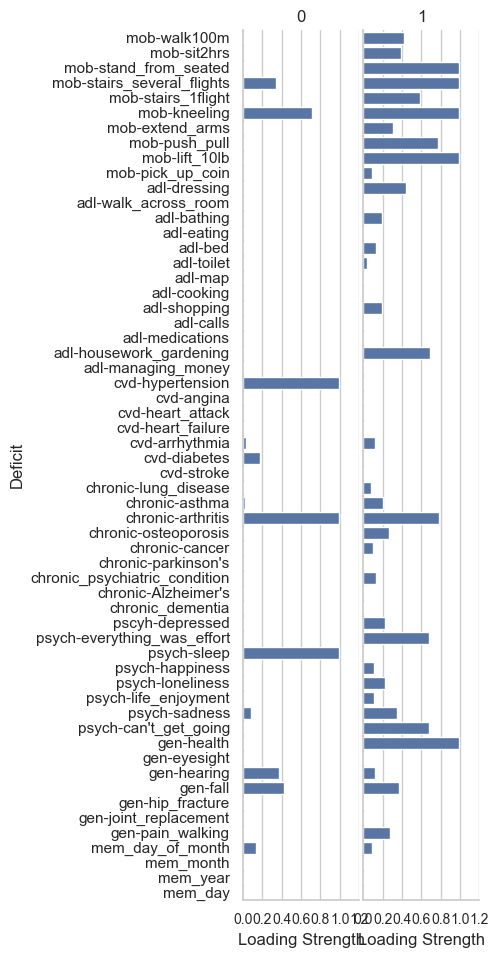

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


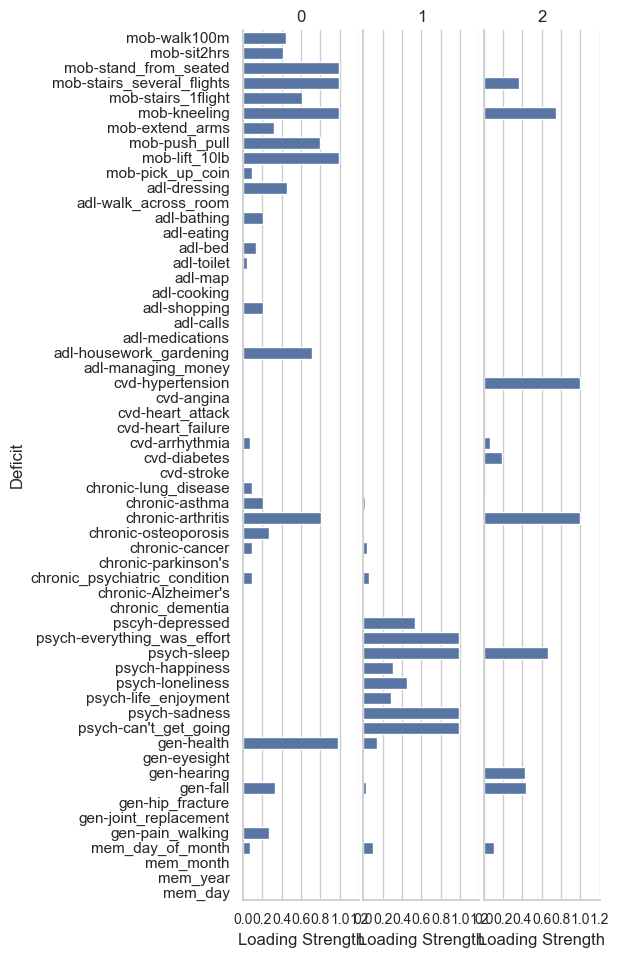

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


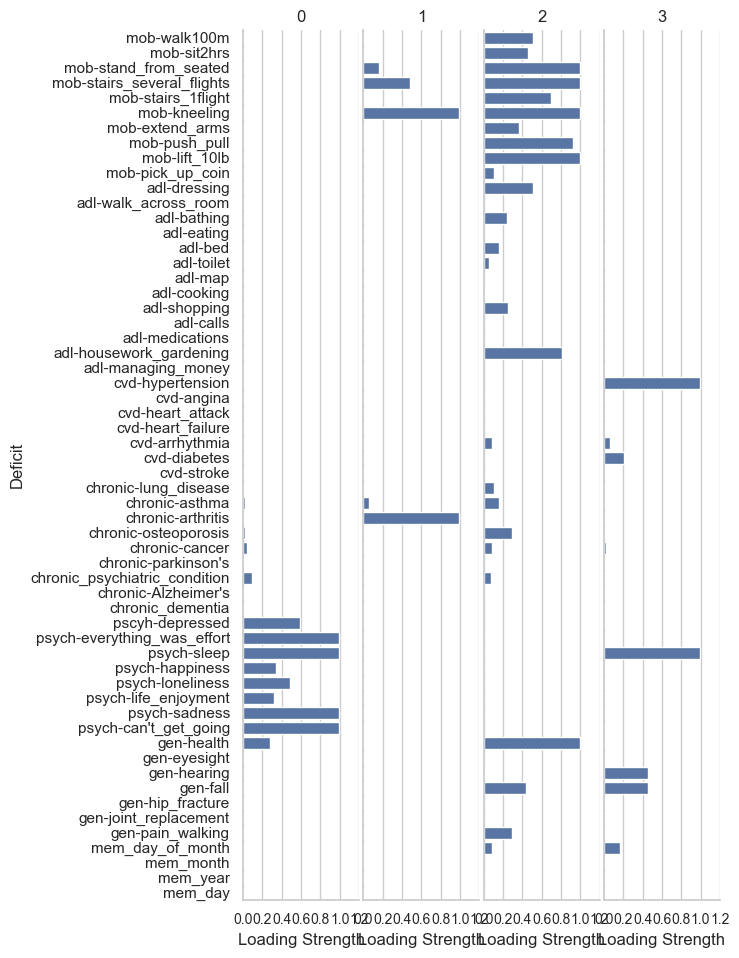

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


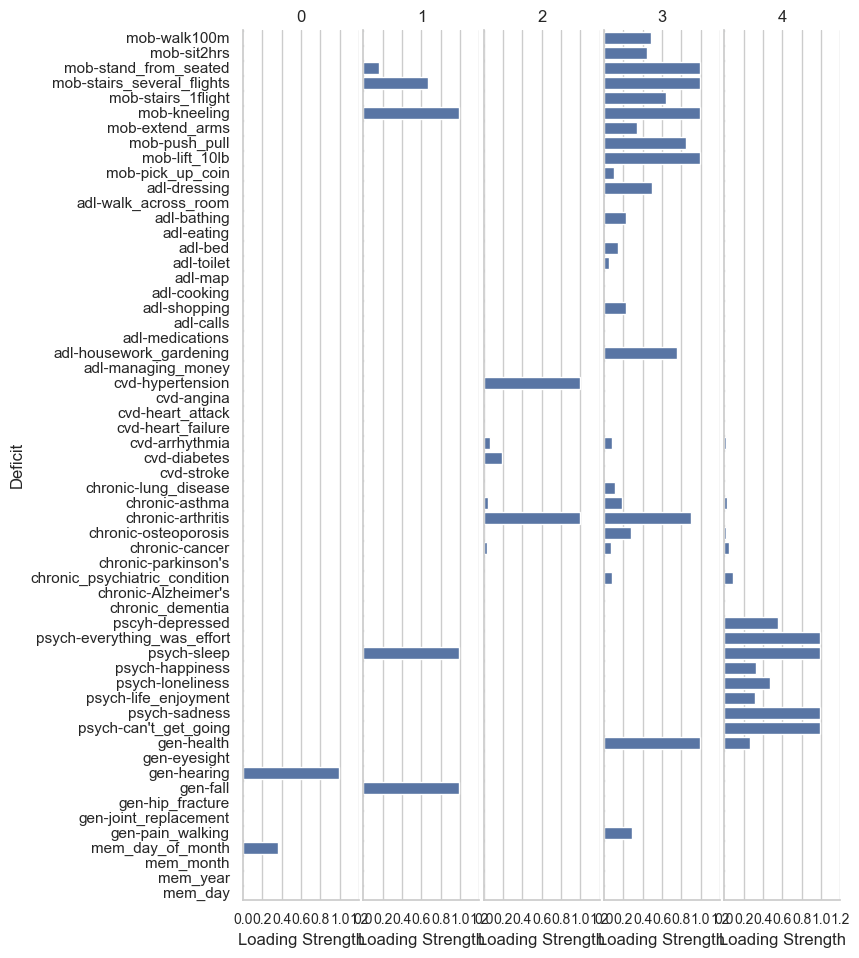

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


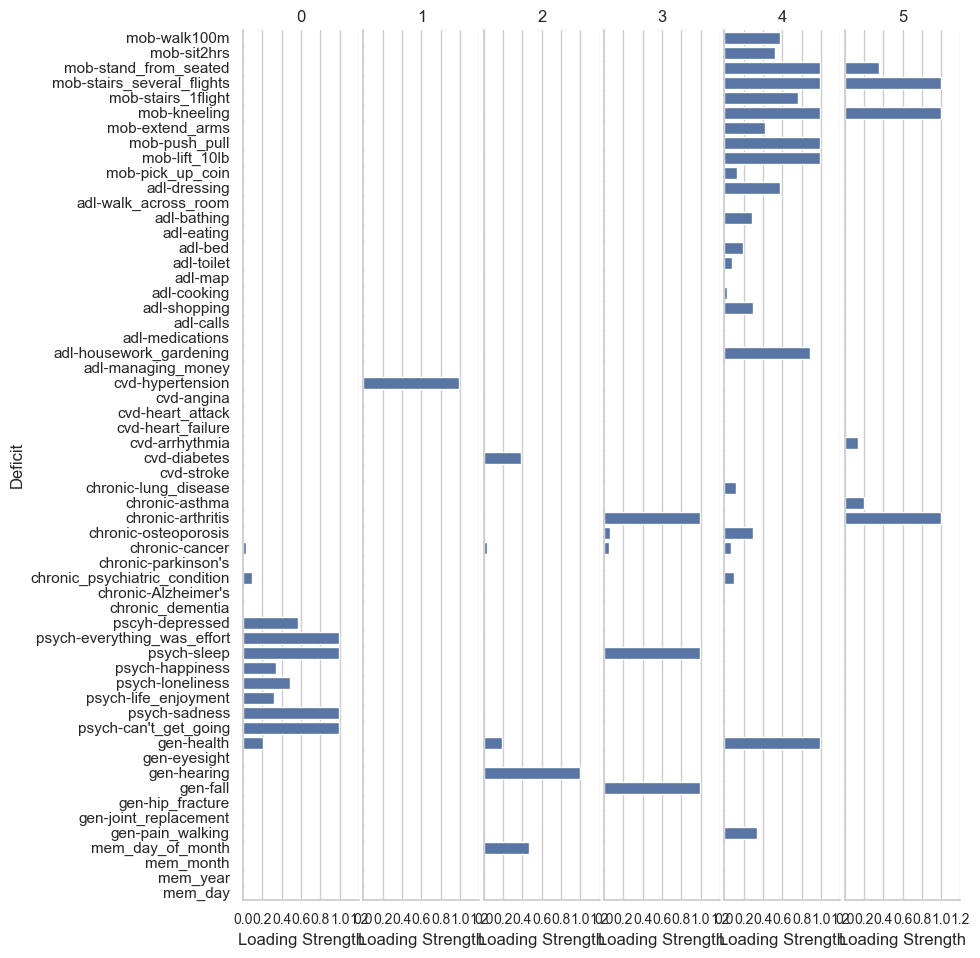

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


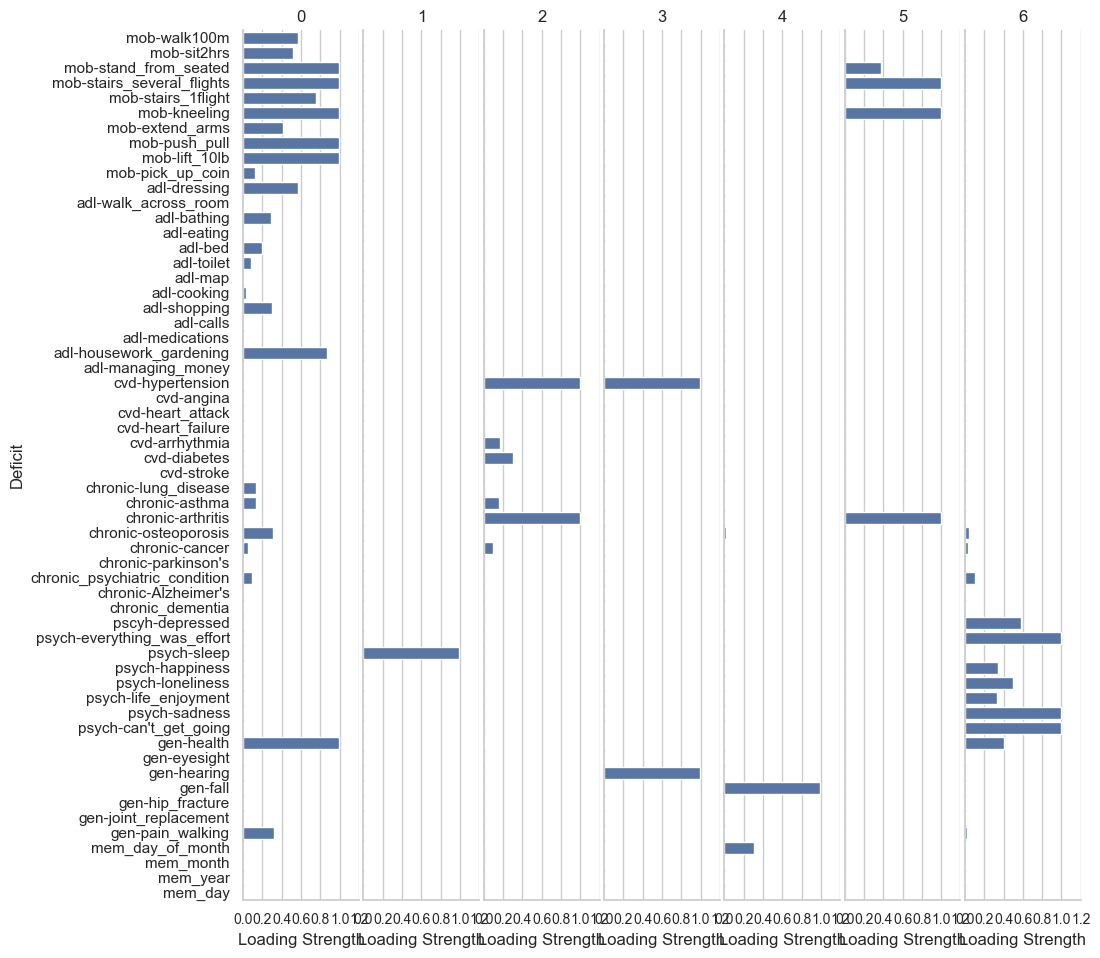

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


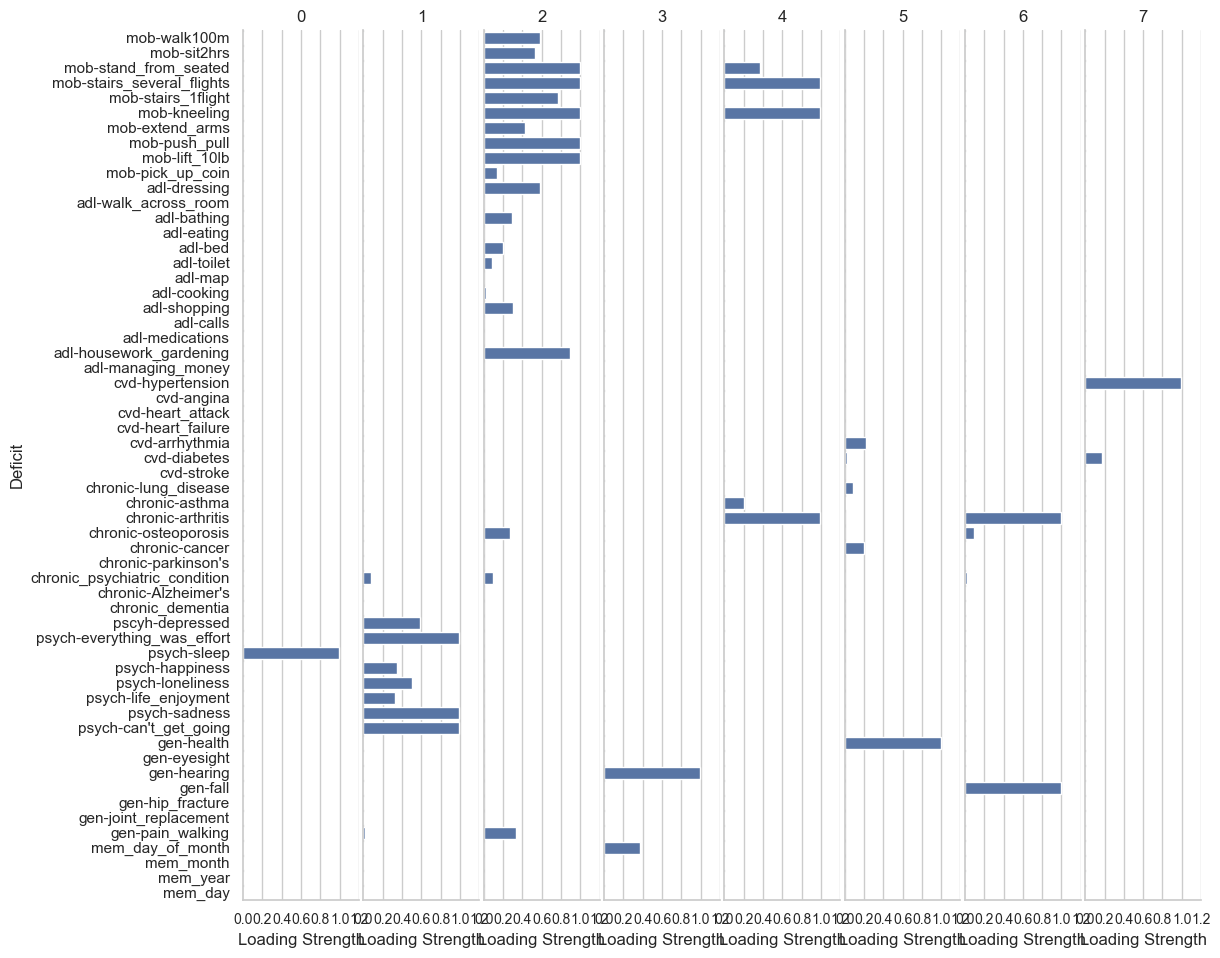

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


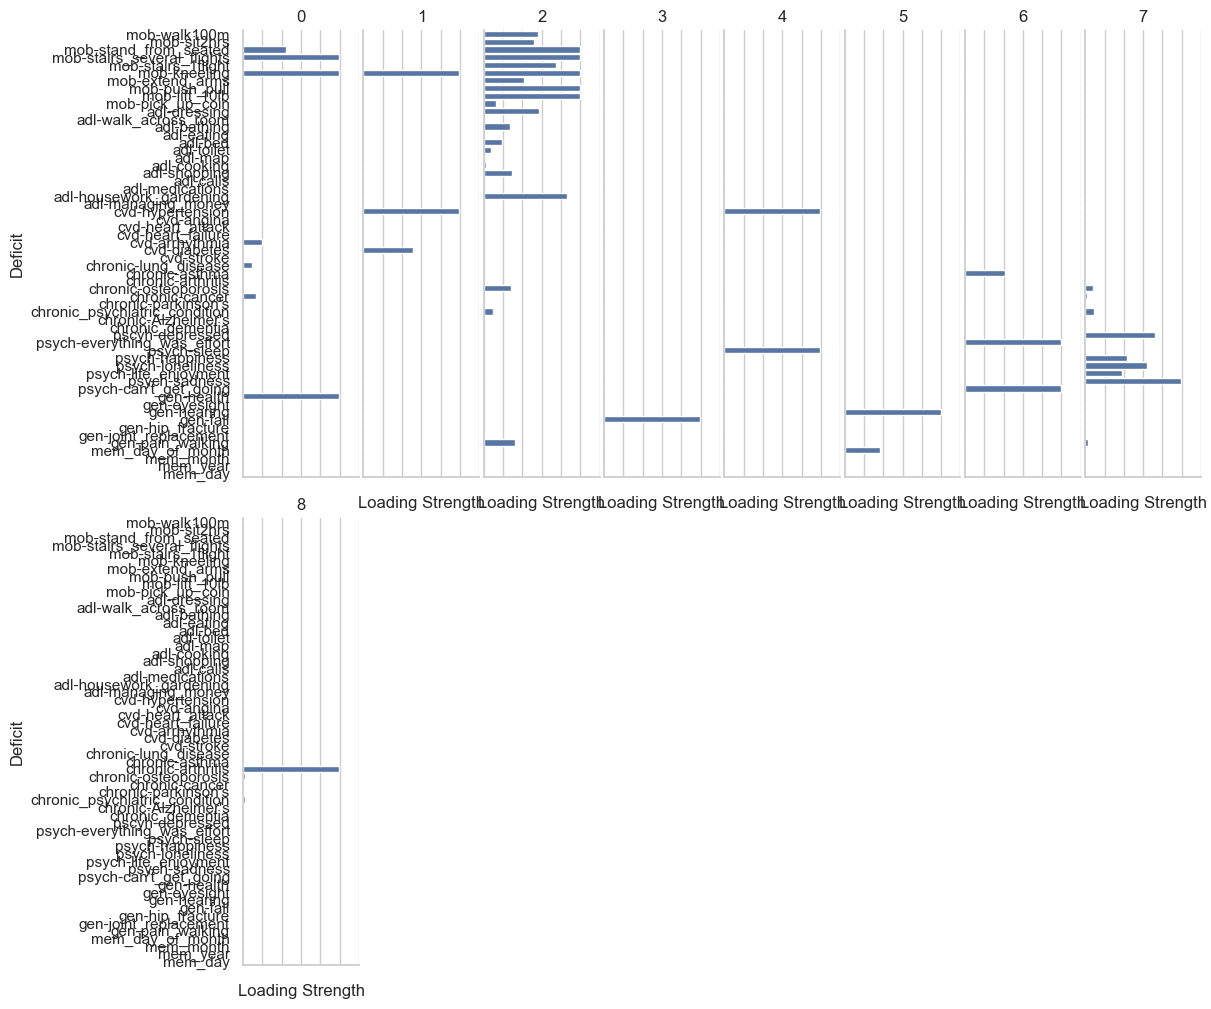

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


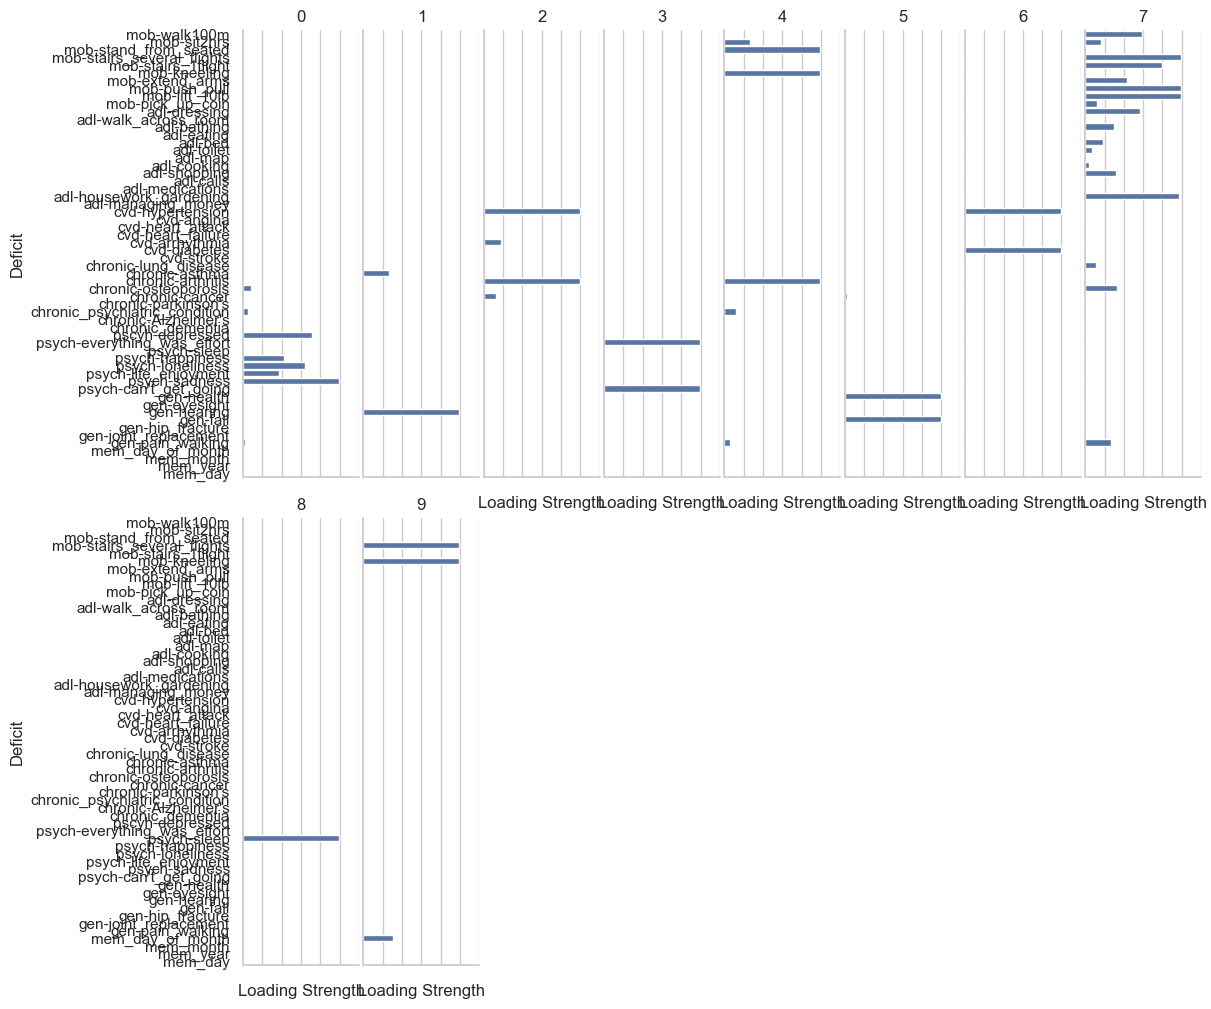

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


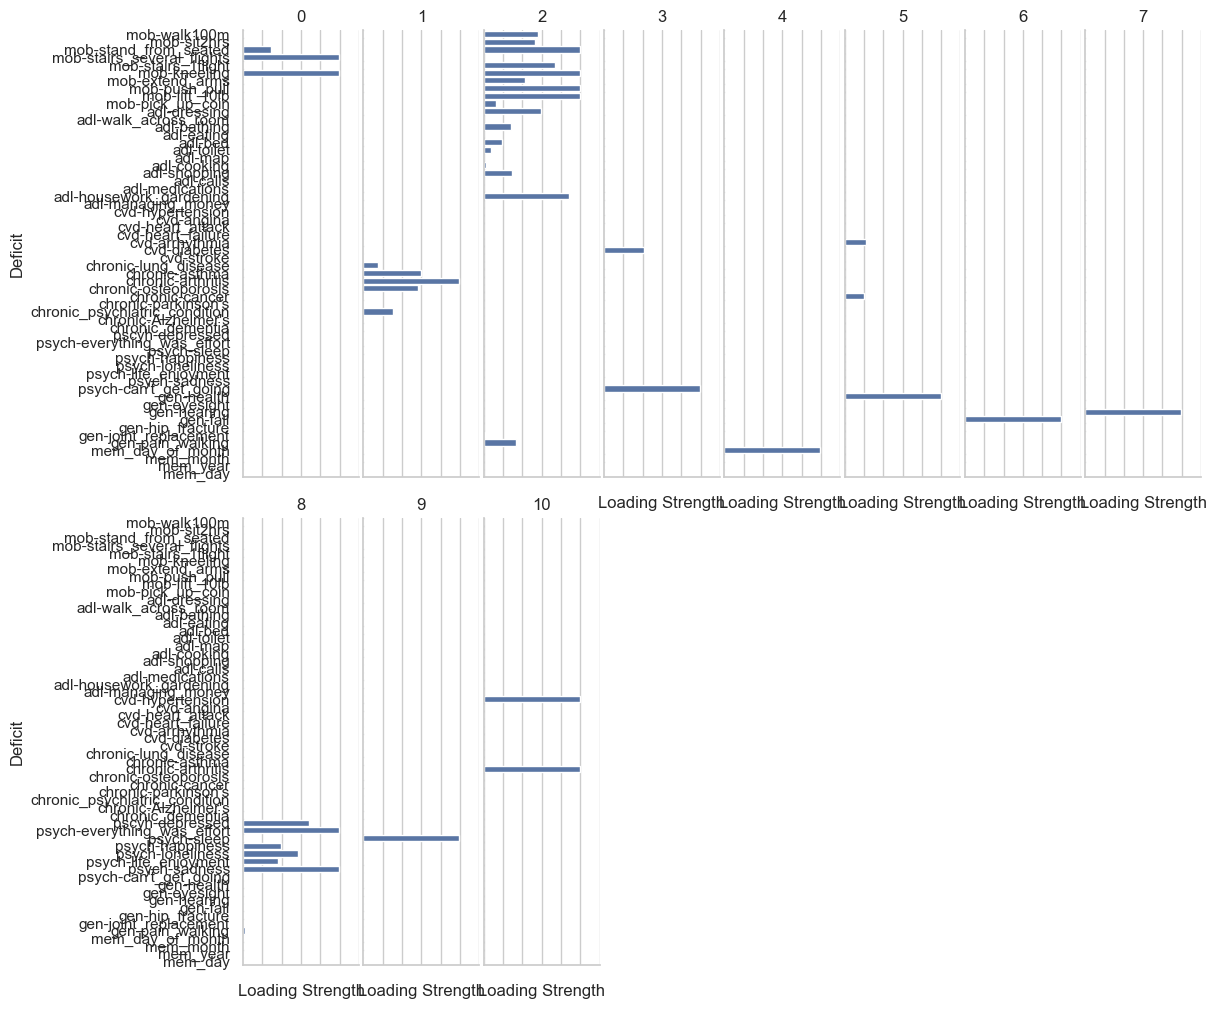

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


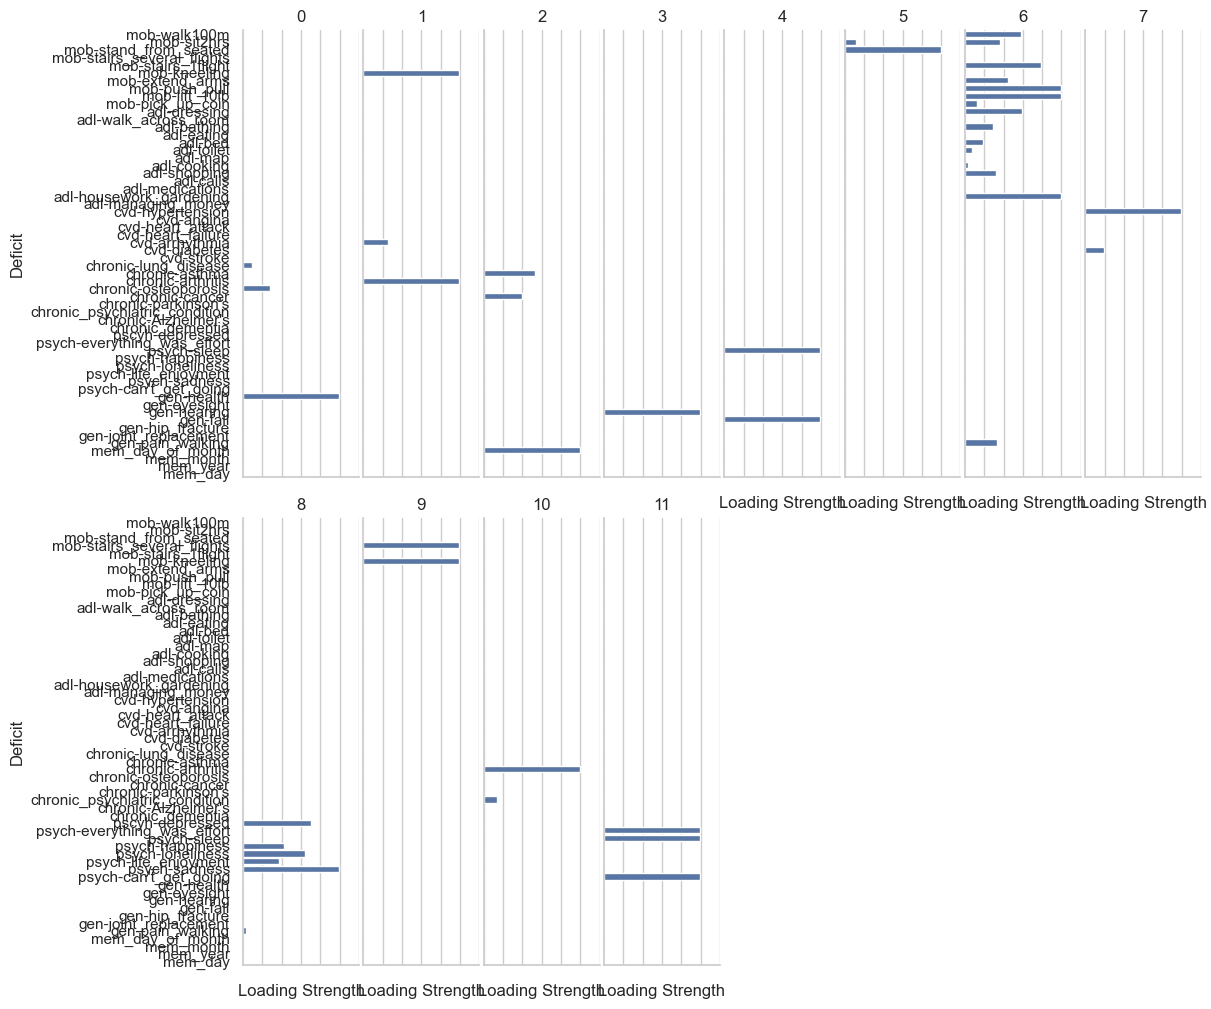

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


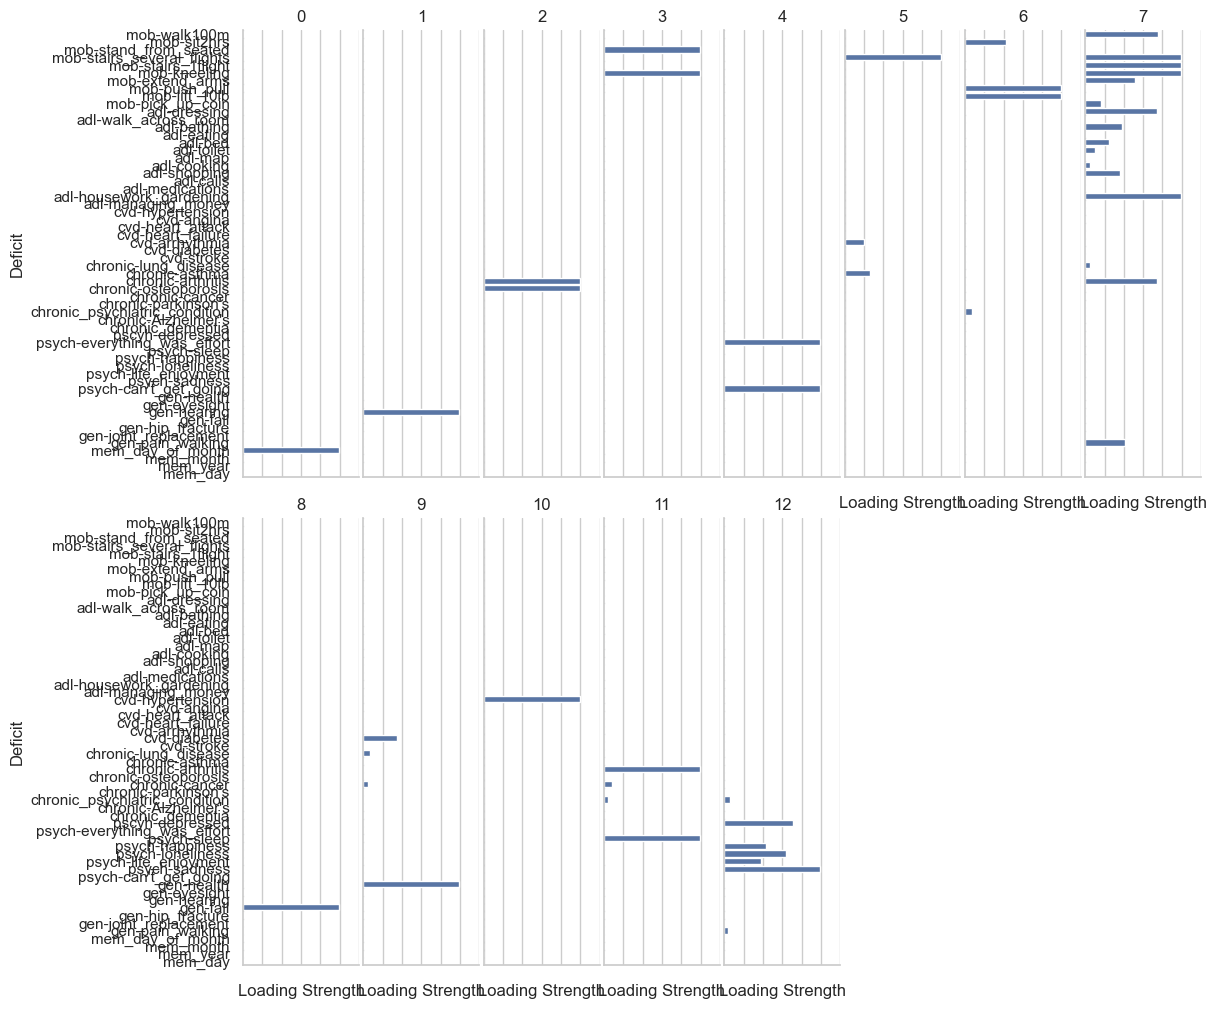

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


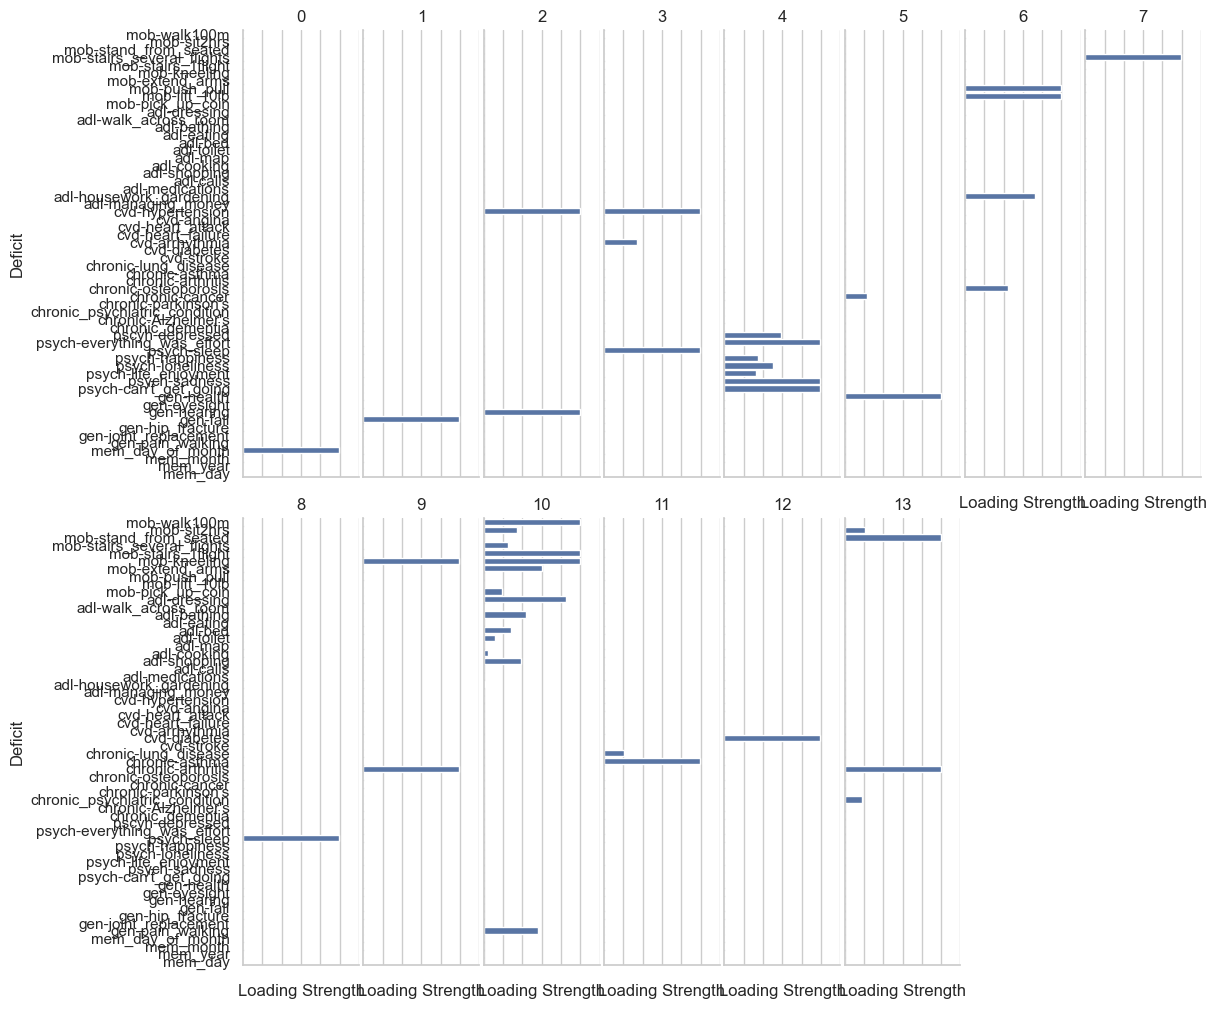

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


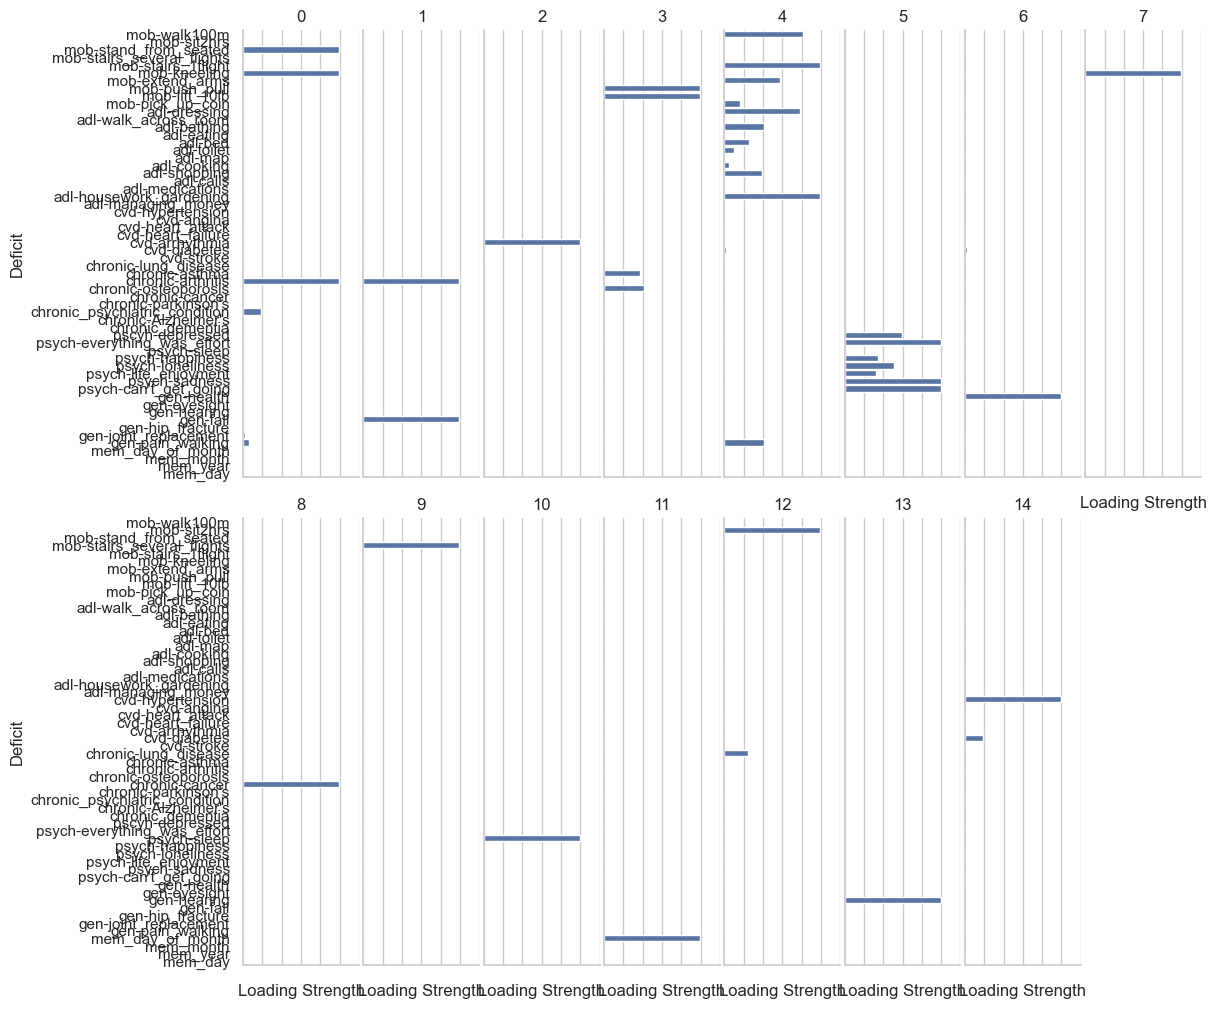

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


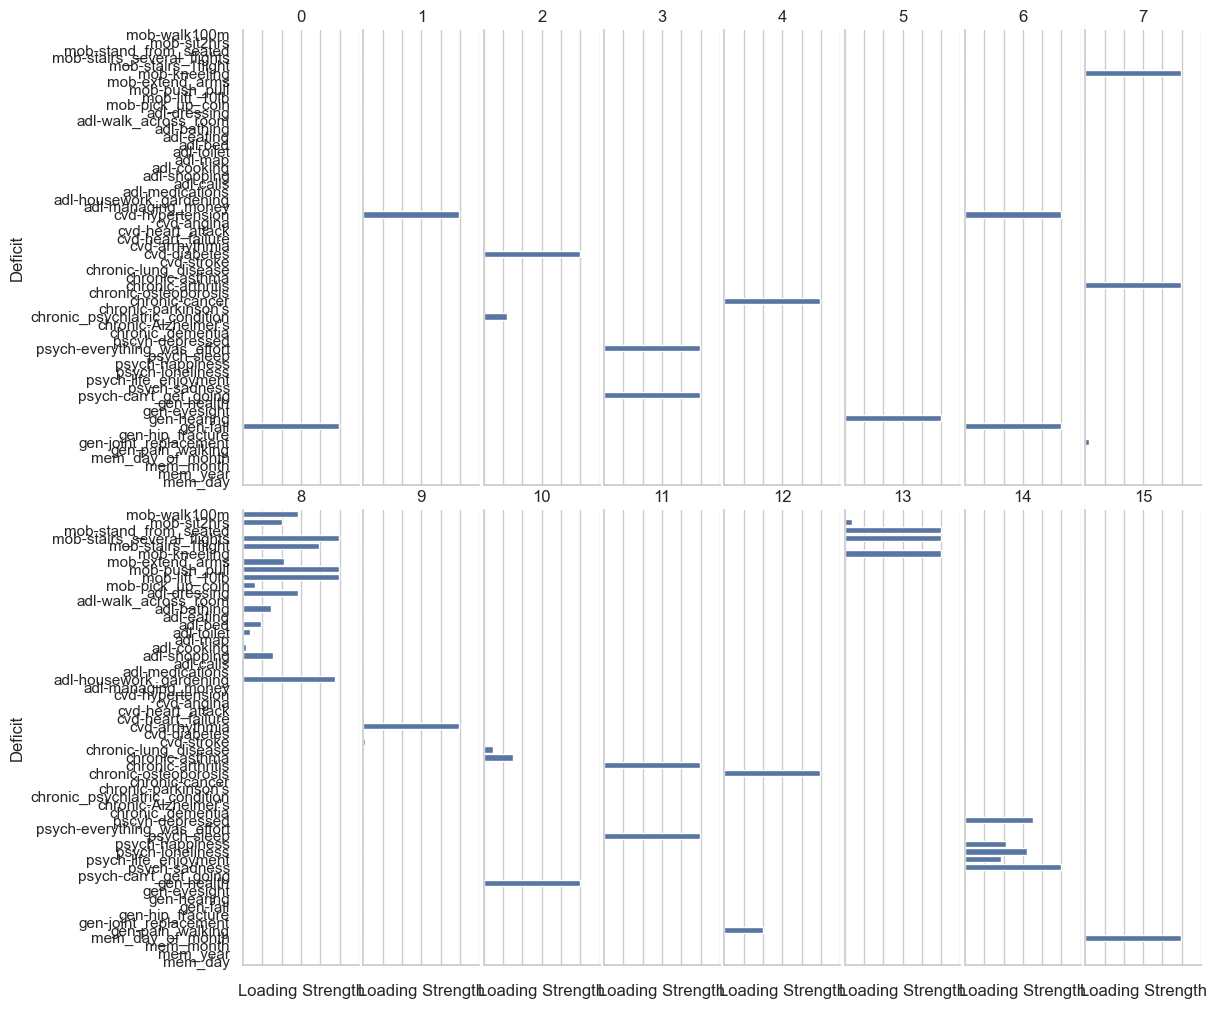

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


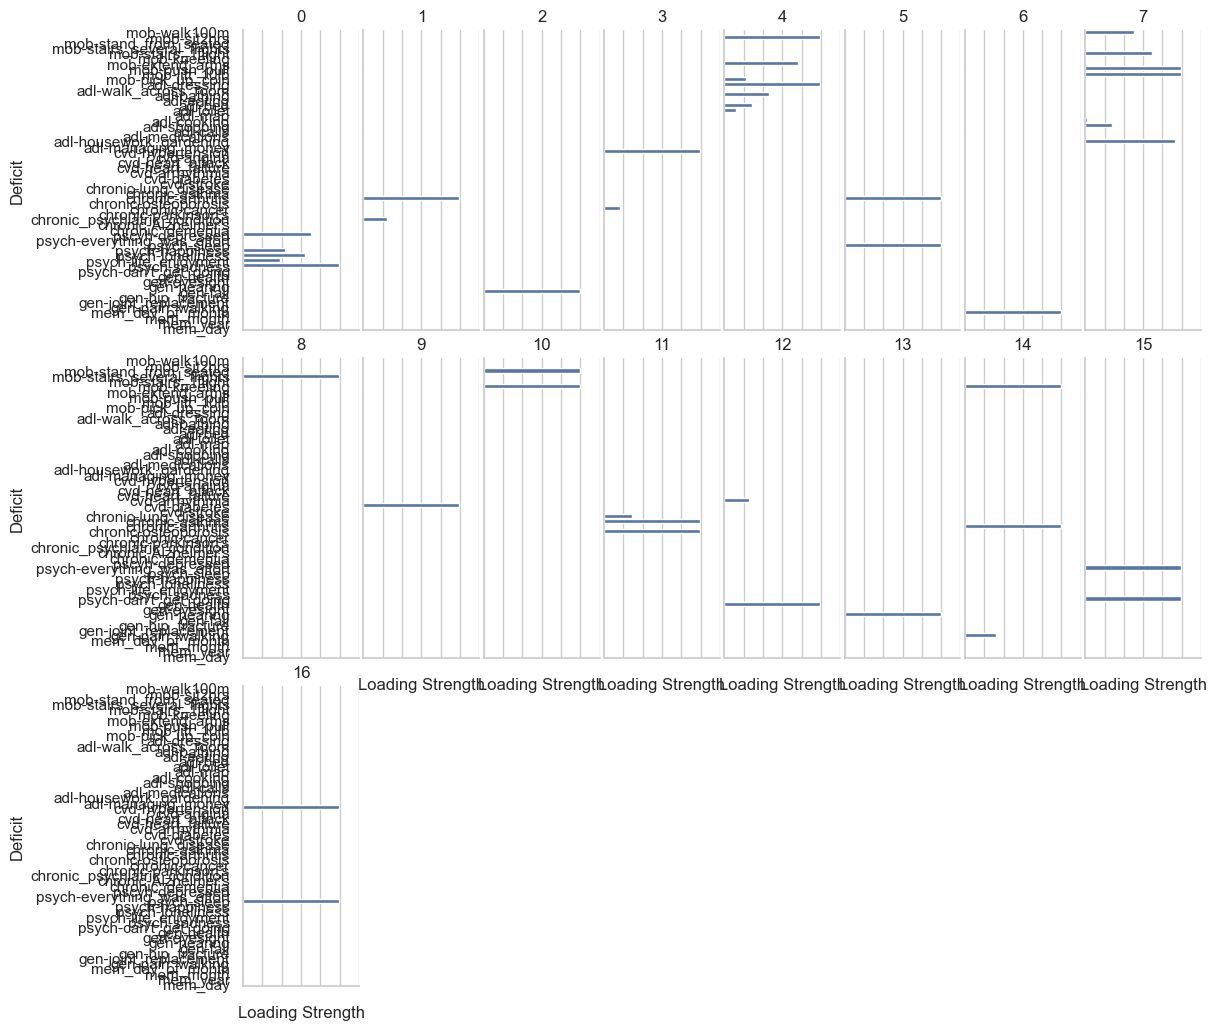

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


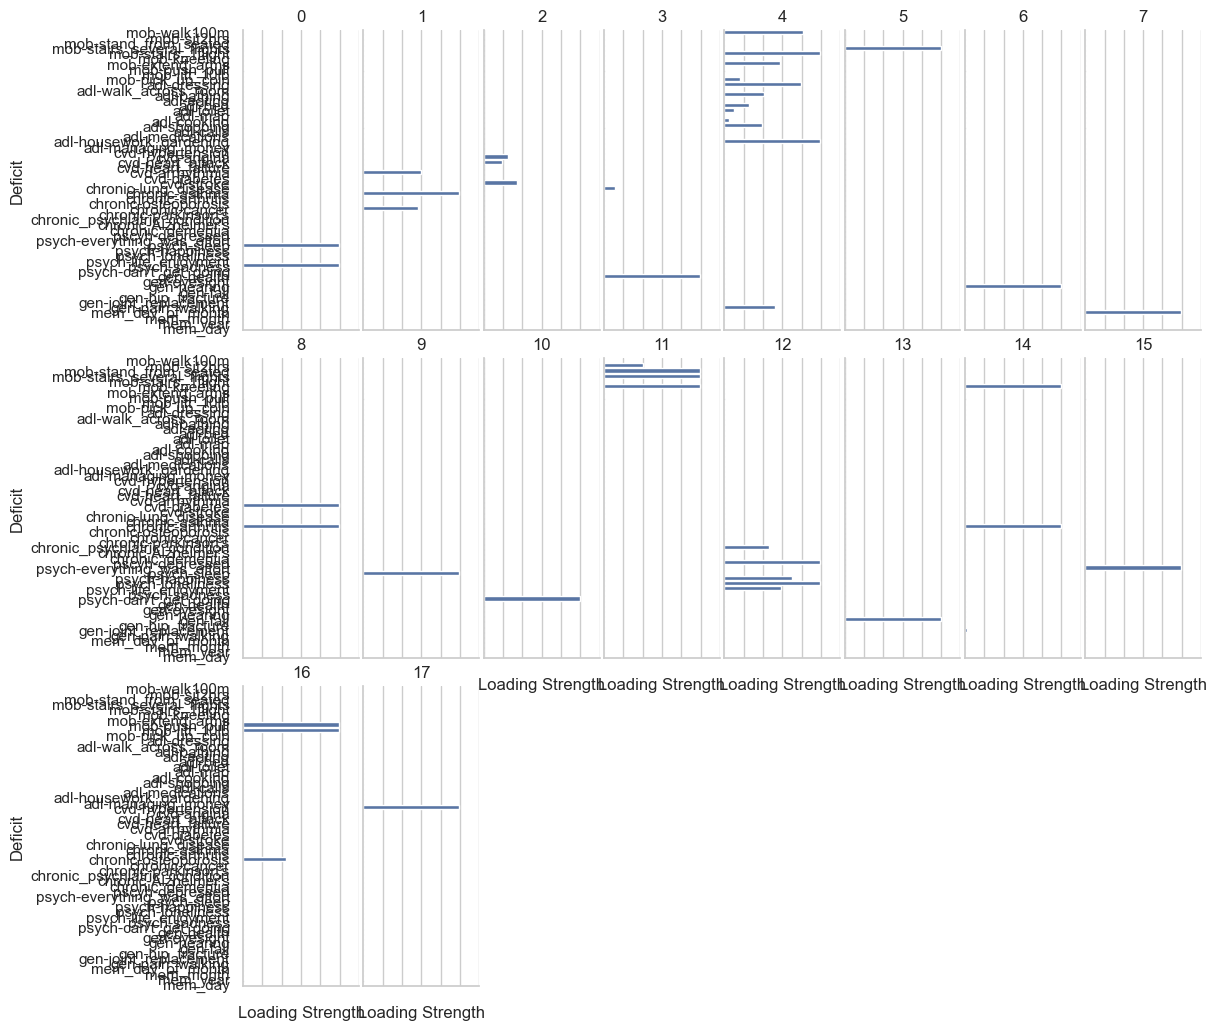

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


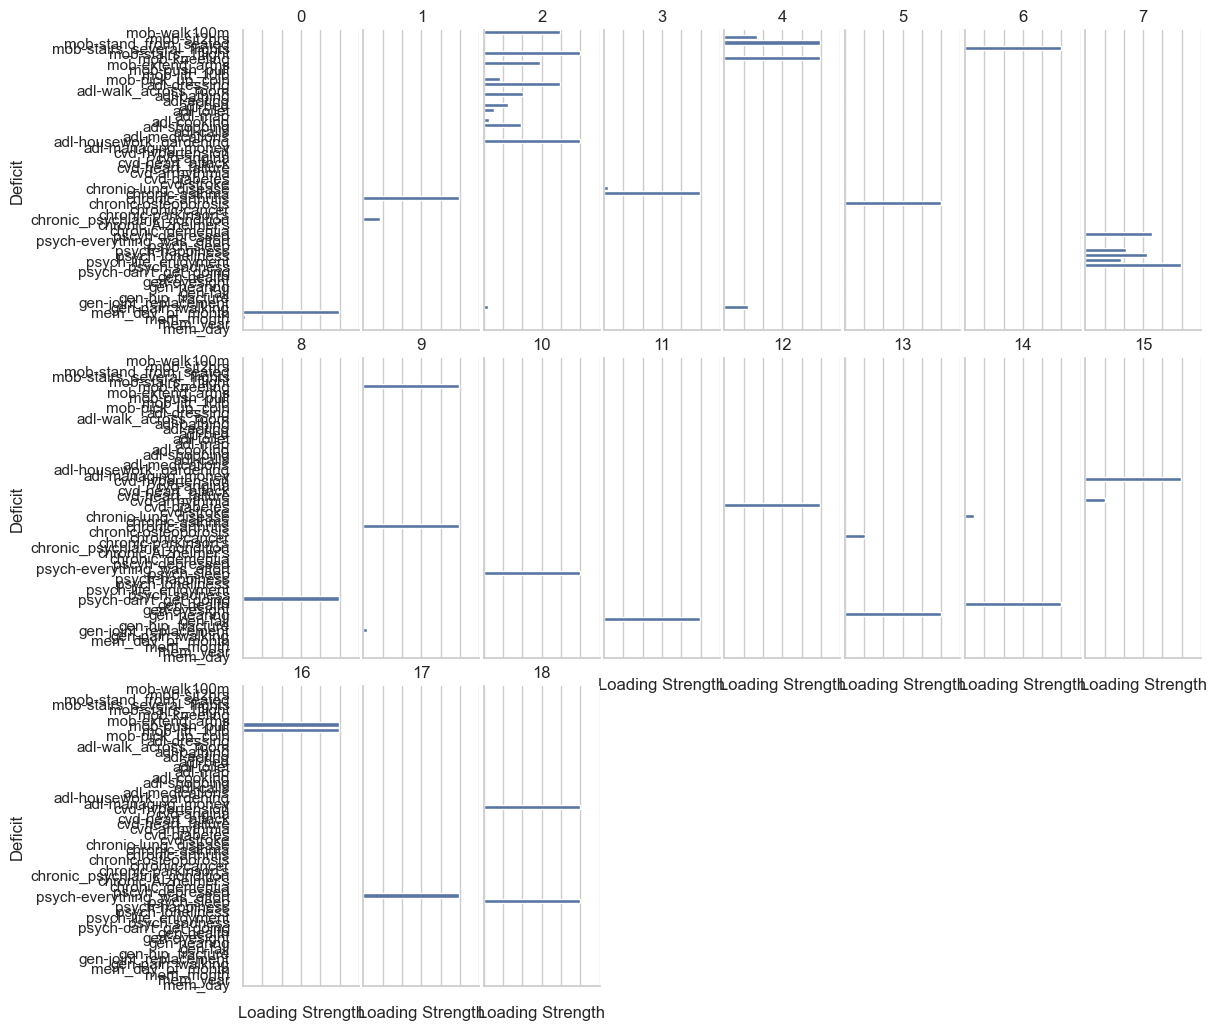

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


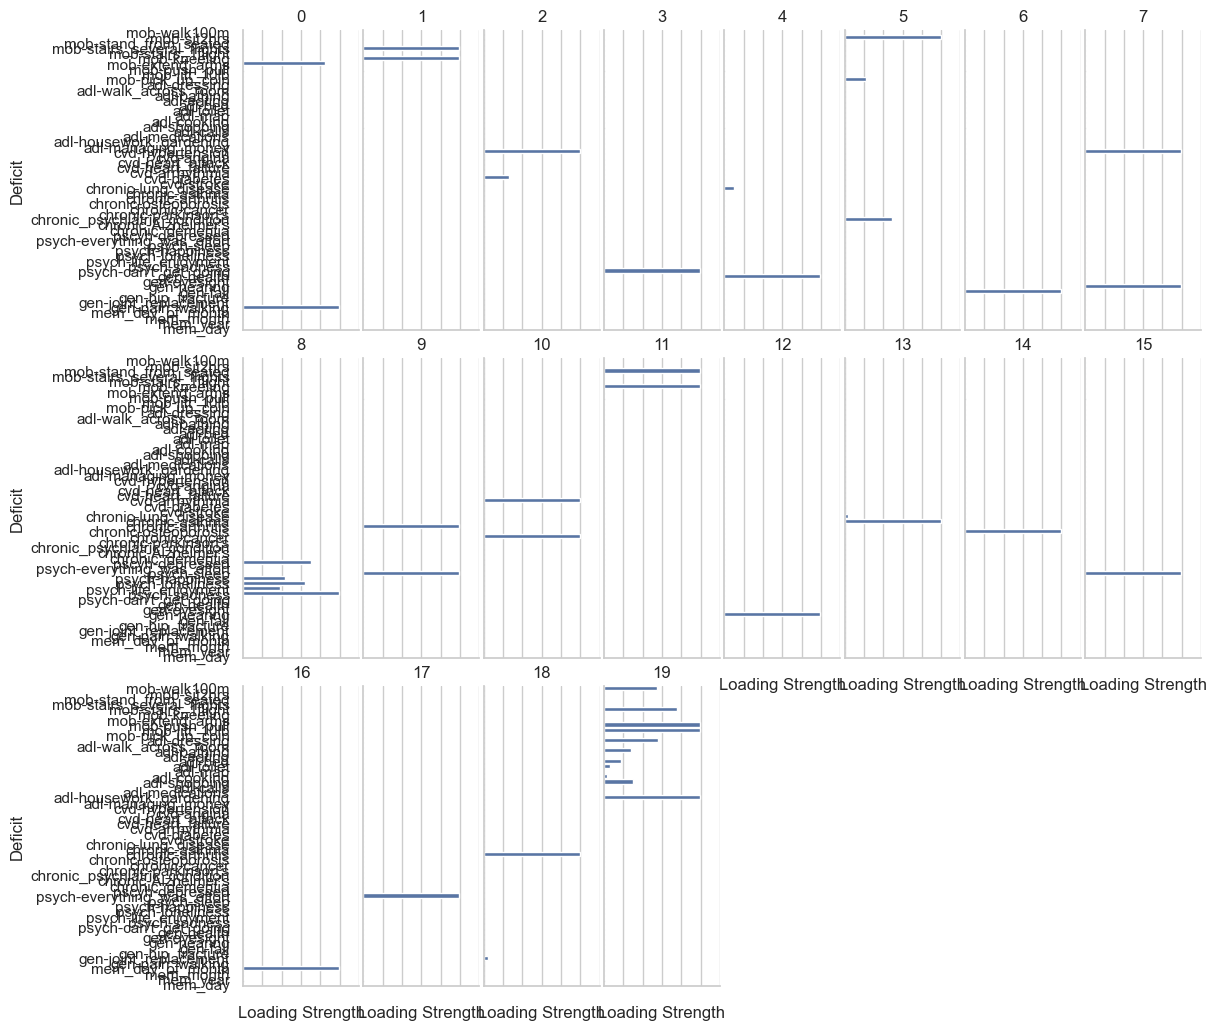

In [401]:
# Plot factor loadings for each model
Z_dict = transform_Z_to_dict(best_models, latent_size_range, deficits)
plot_factor_loadings(Z_dict, latent_size_range)

C:\Users\s1989190\AppData\Local\Temp\ipykernel_24664\3922685429.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


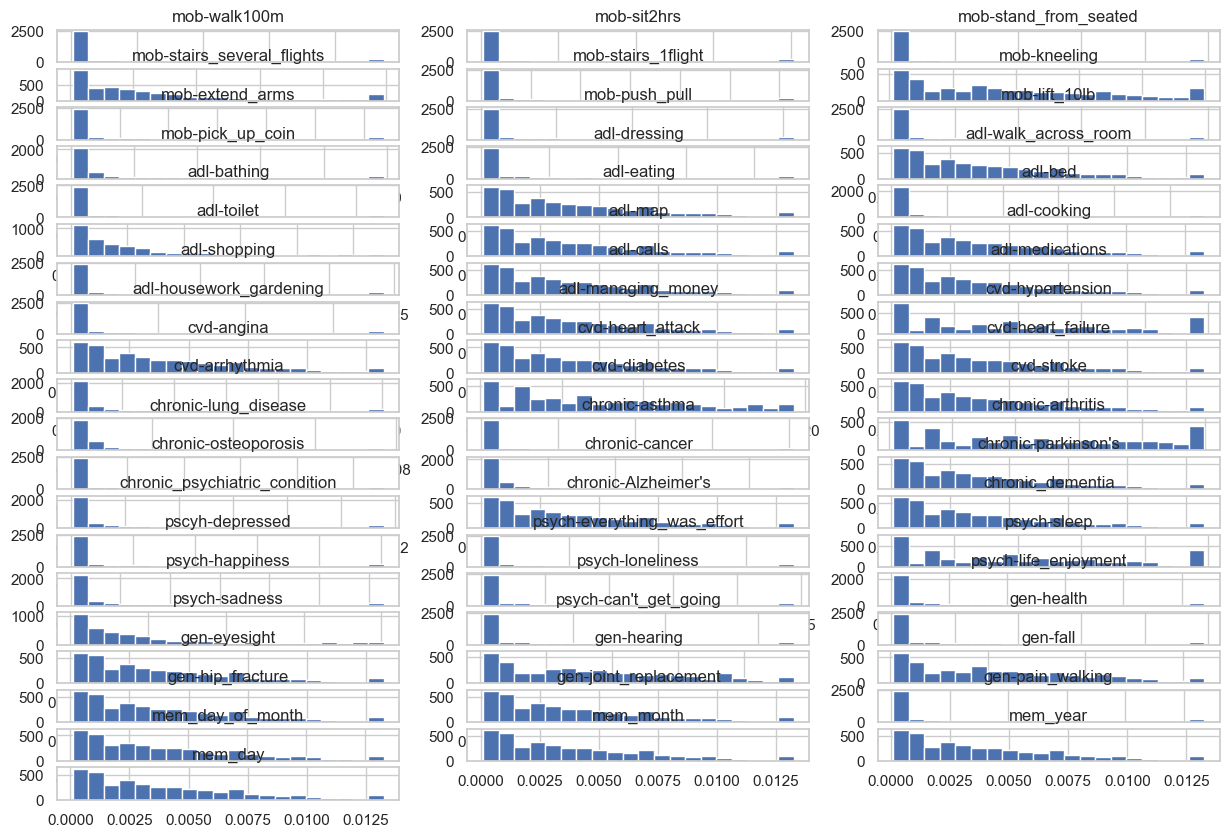

In [163]:
# Plot the X_hat probabilities for each deficit

model_index = 2  # Specify the model index
column_names = deficits.columns.tolist()  # Specify the deficits as column names

plot_column_probabilities(best_models, column_names, model_index)

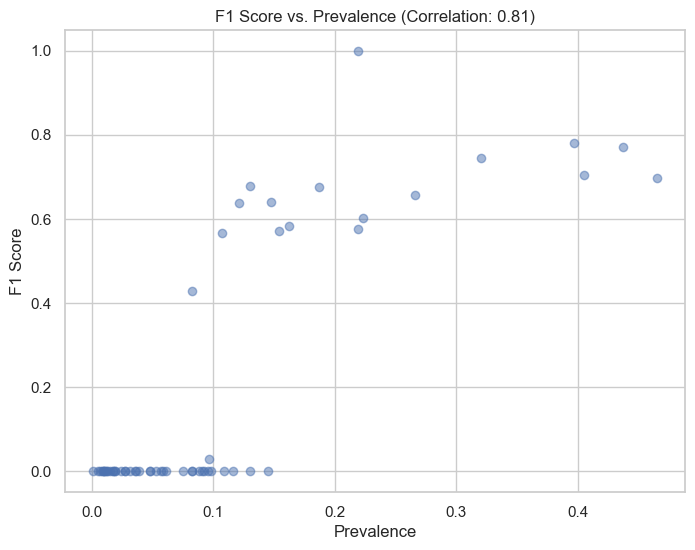

In [404]:
model_index = 5 
column_names = deficits.columns.tolist()
plot_f1_score_vs_prevalence(X, best_models, model_index, column_names)

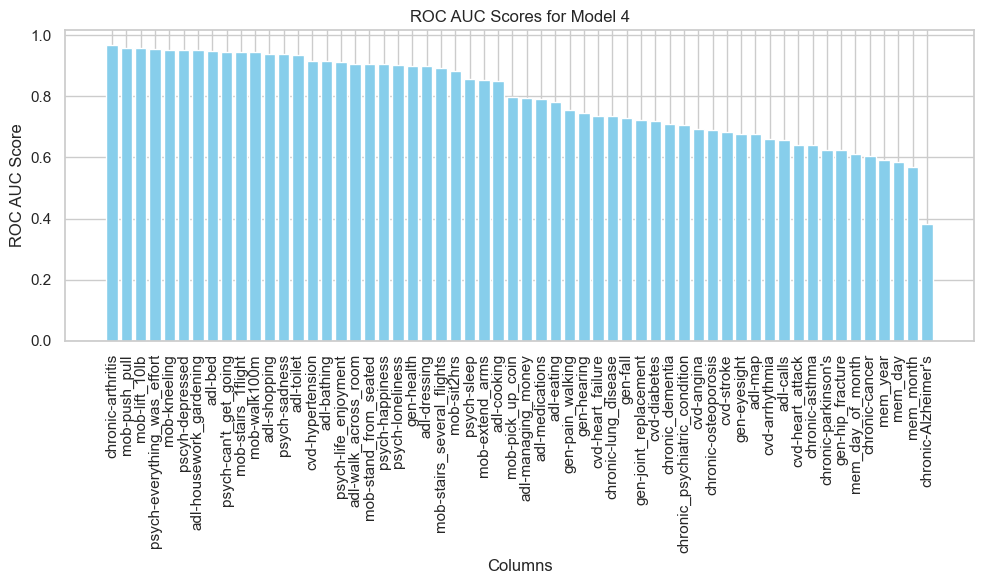

In [405]:
model_index = 4
true_labels = X
column_names = deficits.columns.tolist()
roc_auc_scores = calculate_column_roc_auc(best_models, model_index, true_labels, column_names)
plot_column_roc_auc(best_models, model_index, true_labels, column_names)

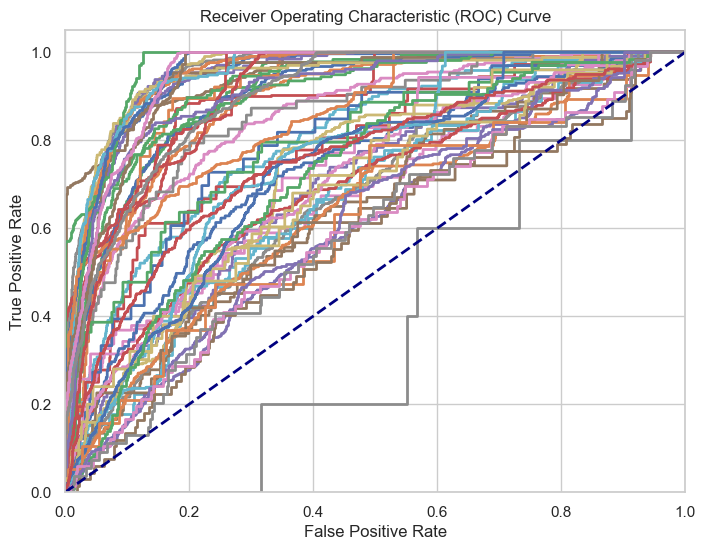

In [406]:
model_index = 4
true_labels = X
column_names = deficits.columns.tolist()
plot_roc_curve_for_each_column(true_labels, best_models, model_index, column_names)

# Outcomes

In [224]:
# Confusion Matrix for reccare
# F1 Score for reccare for each K


In [426]:
def generate_U_dataframe(best_models, model_index, outcomes):
    # Get the U matrix from the specified model
    U = pd.DataFrame(best_models[f"model{model_index}"].U)

    # Generate new column names based on the number of columns
    new_column_names = [f'Factor{i + 1}' for i in range(len(U.columns))]

    # Rename the columns of the DataFrame
    U.columns = new_column_names

    # Append the relevant individual characteristics and outcome columns from the "outcomes" DataFrame
    U["age"] = elsa["age"]
    U["indsex"] = elsa["indsex"]
    U["frailty"] = elsa["frailty"]
    U["reccare"] = elsa["reccare"]
    U["casp19"] = elsa["casp_19"]

    return U

In [427]:
model_index = 2  # Specify the desired model index
U = generate_U_dataframe(best_models, model_index, outcomes)
print(U)

       Factor1   Factor2  age  indsex   frailty  reccare  casp19
0     0.131627  0.006693   73       1  0.017241      0.0    35.0
1     0.421388  0.071474   82       2  0.068966      0.0    43.0
2     0.255560  0.006693   81       2  0.034483      0.0    36.0
3     0.008036  0.006693   68       2  0.000000      0.0    56.0
4     0.327425  0.006693   71       1  0.034483      1.0    36.0
...        ...       ...  ...     ...       ...      ...     ...
3492  0.074557  0.006693   65       2  0.034483      0.0    45.0
3493  0.226355  0.754616   70       1  0.206897      0.0    50.0
3494  0.014570  0.932371   65       2  0.189655      0.0    40.0
3495  0.306619  0.122419   71       1  0.086207      0.0    48.0
3496  0.426765  0.006693   65       2  0.068966      0.0    48.0

[3497 rows x 7 columns]


c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs fai

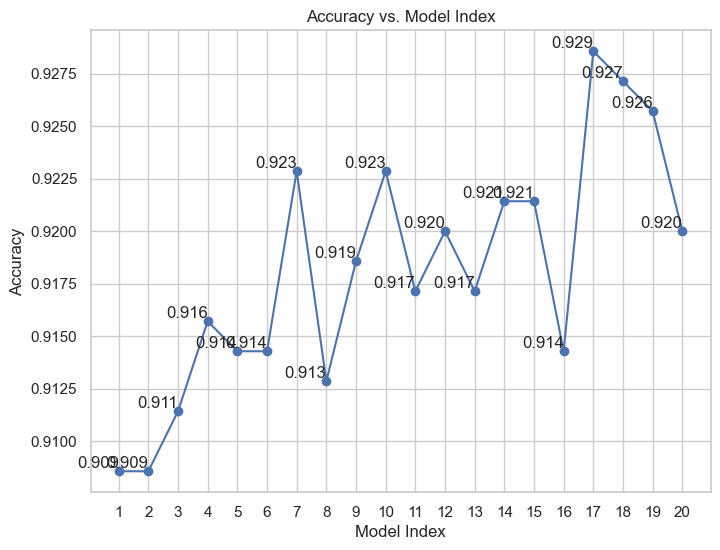

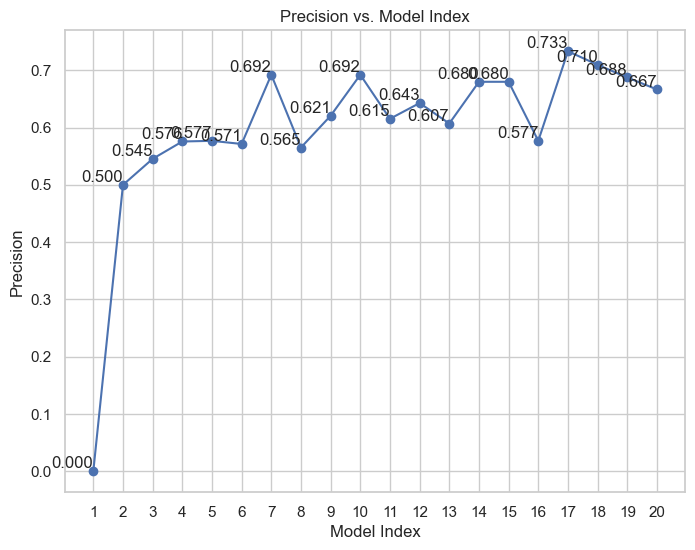

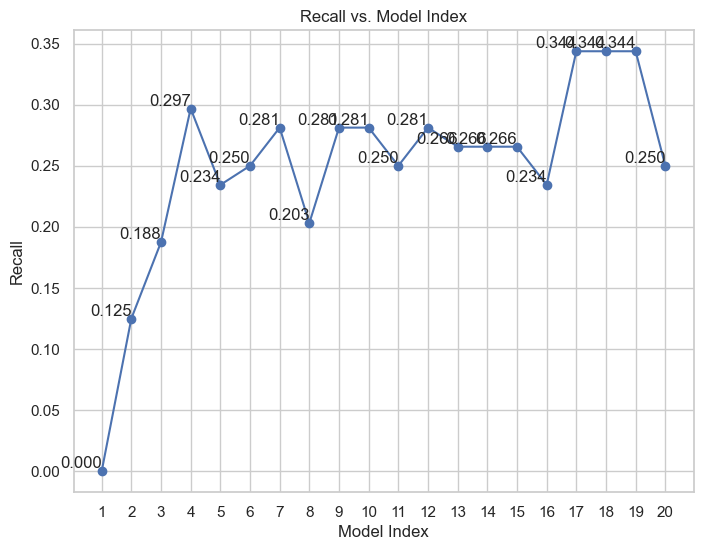

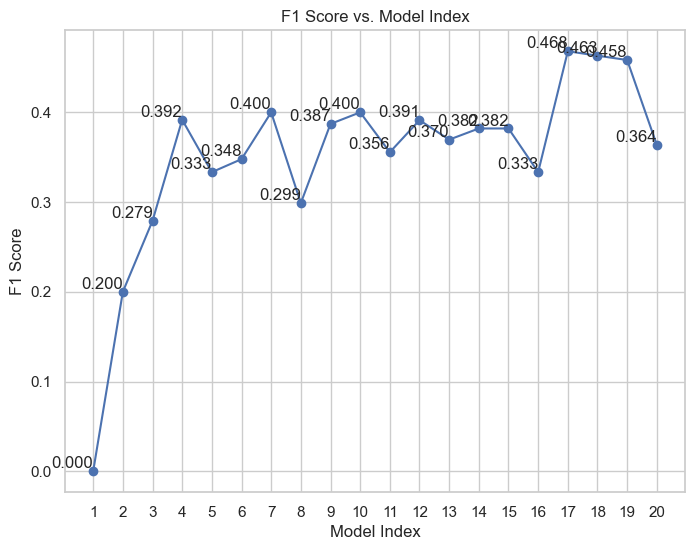

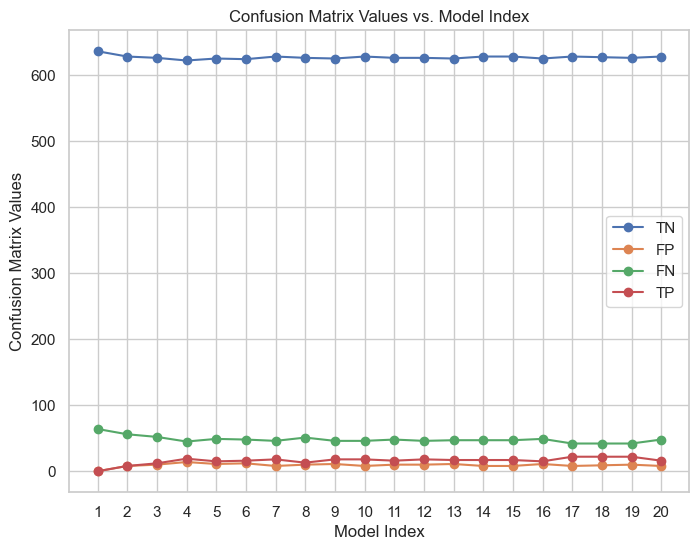

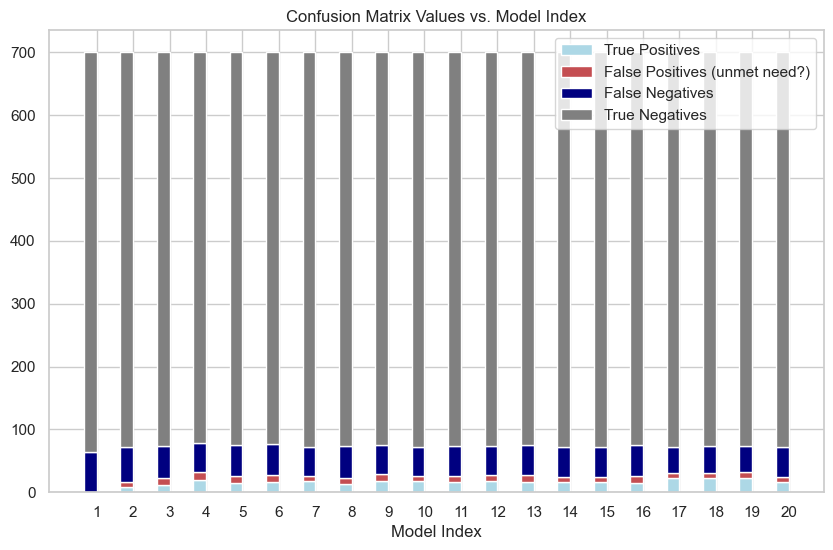

TN: [636, 628, 626, 622, 625, 624, 628, 626, 625, 628, 626, 626, 625, 628, 628, 625, 628, 627, 626, 628] FP (unmet need?): [0, 8, 10, 14, 11, 12, 8, 10, 11, 8, 10, 10, 11, 8, 8, 11, 8, 9, 10, 8] FN: [64, 56, 52, 45, 49, 48, 46, 51, 46, 46, 48, 46, 47, 47, 47, 49, 42, 42, 42, 48] TP: [0, 8, 12, 19, 15, 16, 18, 13, 18, 18, 16, 18, 17, 17, 17, 15, 22, 22, 22, 16]


In [408]:
def train_logistic_regression_models_and_plot_metrics(best_models, index_numbers, outcomes):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    tn_values = []
    fp_values = []
    fn_values = []
    tp_values = []

    for index_number in index_numbers:
        U_model = pd.DataFrame(best_models[f"model{index_number}"].U)
        new_column_names = [f'Factor{i + 1}' for i in range(len(U_model.columns))]
        U_model.columns = new_column_names
        U_model["age"] = elsa["age"]
        U_model["indsex"] = elsa["indsex"]

        # Merge U_model with outcomes
        U_model["reccare"] = elsa["reccare"]
        
        # Split the data into train and test sets (80% train, 20% test)
        X = U_model[new_column_names + ["age", "indsex"]]
        y = U_model['reccare']
        X = X[~y.isna()]
        y = y.dropna()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and fit a logistic regression model
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Extract TP, FP, FN, TN
        tp = cm[1, 1]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tn = cm[0, 0]
        tn_values.append(tn)
        fp_values.append(fp)
        fn_values.append(fn)
        tp_values.append(tp)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate precision
        precision = precision_score(y_test, y_pred)
        precision_scores.append(precision)

        # Calculate recall
        recall = recall_score(y_test, y_pred)
        recall_scores.append(recall)

        # Calculate F1 scores
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

    # Plot the accuracy scores
    plt.figure(figsize=(8, 6))
    plt.plot(index_numbers, accuracy_scores, marker='o')
    plt.title('Accuracy vs. Model Index')
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(index_numbers)

    # Add accuracy labels to each point
    for i, acc in enumerate(accuracy_scores):
        plt.text(index_numbers[i], acc, f'{acc:.3f}', ha='right', va='bottom')

    plt.show()

    # Plot the precision scores
    plt.figure(figsize=(8, 6))
    plt.plot(index_numbers, precision_scores, marker='o')
    plt.title('Precision vs. Model Index')
    plt.xlabel('Model Index')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.xticks(index_numbers)

    # Add precision labels to each point
    for i, precision in enumerate(precision_scores):
        plt.text(index_numbers[i], precision, f'{precision:.3f}', ha='right', va='bottom')

    plt.show()

    # Plot the recall scores
    plt.figure(figsize=(8, 6))
    plt.plot(index_numbers, recall_scores, marker='o')
    plt.title('Recall vs. Model Index')
    plt.xlabel('Model Index')
    plt.ylabel('Recall')
    plt.grid(True)
    plt.xticks(index_numbers)

    # Add recall labels to each point
    for i, recall in enumerate(recall_scores):
        plt.text(index_numbers[i], recall, f'{recall:.3f}', ha='right', va='bottom')

    plt.show()

    # Plot the f1 scores
    plt.figure(figsize=(8, 6))
    plt.plot(index_numbers, f1_scores, marker='o')
    plt.title('F1 Score vs. Model Index')
    plt.xlabel('Model Index')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.xticks(index_numbers)

    # Add recall labels to each point
    for i, score in enumerate(f1_scores):
        plt.text(index_numbers[i], score, f'{score:.3f}', ha='right', va='bottom')

    plt.show()


    # Plot the confusion matrix values
    plt.figure(figsize=(8, 6))
    plt.plot(index_numbers, tn_values, marker='o', label='TN')
    plt.plot(index_numbers, fp_values, marker='o', label='FP')
    plt.plot(index_numbers, fn_values, marker='o', label='FN')
    plt.plot(index_numbers, tp_values, marker='o', label='TP')
    plt.title('Confusion Matrix Values vs. Model Index')
    plt.xlabel('Model Index')
    plt.ylabel('Confusion Matrix Values')
    plt.grid(True)
    plt.xticks(index_numbers)
    plt.legend()

    plt.show()

    # Create a stacked bar chart of confusion matrix values
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(index_numbers))

    plt.bar(index, tp_values, bar_width, label='True Positives', color='lightblue')
    plt.bar(index, fp_values, bar_width, label='False Positives (unmet need?)', color='r', bottom=tp_values)
    plt.bar(index, fn_values, bar_width, label='False Negatives', color='navy', bottom=[tp_values[i] + fp_values[i] for i in index])
    plt.bar(index, tn_values, bar_width, label='True Negatives', color='grey', bottom=[tp_values[i] + fp_values[i] + fn_values[i] for i in index])

    plt.xlabel('Model Index')
    plt.title('Confusion Matrix Values vs. Model Index')
    plt.xticks([i + bar_width / 2 for i in index], index_numbers)
    plt.legend()

    plt.show()

    print("TN:", tn_values, 
          "FP (unmet need?):", fp_values,
          "FN:", fn_values, 
          "TP:", tp_values)

# Example usage
index_numbers = list(range(1,21))
train_logistic_regression_models_and_plot_metrics(best_models, index_numbers=index_numbers, outcomes=elsa["reccare"])

In [391]:
# Logistic regression predicting reccare from frailty score

# Define the features (independent variables) and the target (dependent variable)
X = elsa[["frailty", "age", "indsex"]]  # Include all factor columns
y = elsa["reccare"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

print("Accuracy:", accuracy,
      "Precision:", precision,
      "Recall:", recall,
      "F1 Score:", f1,
      "TP:", tp,
      "FP (unmet need?):", fp,
      "FN:", fn,
      "TN:", tn)

Accuracy: 0.9128571428571428 Precision: 0.7142857142857143 Recall: 0.078125 F1 Score: 0.14084507042253522 TP: 5 FP (unmet need?): 2 FN: 59 TN: 634


In [387]:
np.unique(y_pred, return_counts= True)

(array([0., 1.]), array([693,   7], dtype=int64))

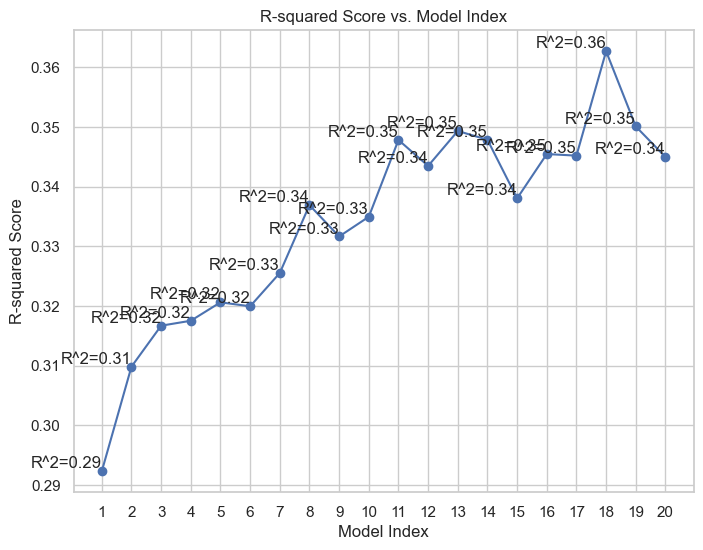

[0.29230901226997086, 0.3098363204418655, 0.3167009904013113, 0.31752927007756127, 0.32061597161059496, 0.3199508428451212, 0.3255291657105315, 0.33691272126881777, 0.3316477025549054, 0.33495270701103763, 0.34782442470826325, 0.3434764336383015, 0.3493274681854094, 0.3478590908589674, 0.3380354901084075, 0.3454656482539915, 0.3451970983266591, 0.3626905494471596, 0.3500898712780707, 0.3449689189862123]
X shape: (3497, 22)


In [409]:
# Linear regression to predict QoL and plot r2 scores
def train_linear_regression_models_and_plot_r2(best_models, index_numbers, outcomes):
    r2_scores = []

    for index_number in index_numbers:
        U_model = pd.DataFrame(best_models[f"model{index_number}"].U)
        new_column_names = [f'Factor{i + 1}' for i in range(len(U_model.columns))]
        U_model.columns = new_column_names
        U_model["age"] = elsa["age"]
        U_model["indsex"] = elsa["indsex"]

        # Merge U_model with outcomes
        U_model["casp_19"] = elsa["casp_19"]
        
        # Split the data into train and test sets (80% train, 20% test)
        X = U_model[new_column_names + ["age", "indsex"]]
        y = U_model['casp_19']
        X = X[~y.isna()]
        y = y.dropna()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and fit a linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate R-squared score
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

    # Plot the accuracy scores
    plt.figure(figsize=(8, 6))
    plt.plot(index_numbers, r2_scores, marker='o')
    plt.title('R-squared Score vs. Model Index')
    plt.xlabel('Model Index')
    plt.ylabel('R-squared Score')
    plt.grid(True)
    plt.xticks(index_numbers)

    # Add R-squared labels to each point
    for i, r2 in enumerate(r2_scores):
        plt.text(index_numbers[i], r2, f'R^2={r2:.2f}', ha='right', va='bottom')


    plt.show()

    print(r2_scores)
    print("X shape:", X.shape)

# Example usage
train_linear_regression_models_and_plot_r2(best_models, index_numbers=index_numbers, outcomes=elsa["casp_19"])

In [358]:
# Linear regression predicting QoL from frailty index score

# Define the features (independent variables) and the target (dependent variable)
X = elsa[["frailty", "age", "indsex"]]  # Include all factor columns
y = elsa["casp_19"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

print("R2:", r2)

R2: 0.3347855953452542


# Individual Characteristics

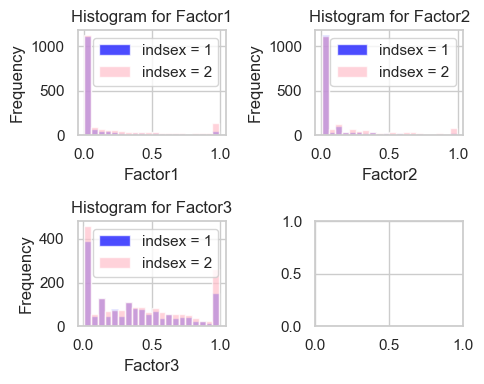

In [456]:
# Histogram of U > 0.1, by sex and age_group
#U # Patients - Latent Factors

# List of columns you want to create histograms for
columns_to_plot = [col for col in U.columns if col.startswith('Factor')]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 4))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Create histograms for each column and plot them, differentiating by 'indsex'
colors = {1: 'blue', 2: 'pink'}

for i, column in enumerate(columns_to_plot):
    for indsex_value, color in colors.items():
        data = U[U['indsex'] == indsex_value][column]
        axes[i].hist(data, bins=20, color=color, alpha=0.7, label=f'indsex = {indsex_value}')
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [461]:
U[U["Factor1"] < 0.01]

Factor1   Factor2   Factor3  age  indsex   frailty  reccare  casp19
0     0.006693  0.007276  0.145767   73       1  0.017241      0.0    35.0
2     0.007354  0.007320  0.289494   81       2  0.034483      0.0    36.0
3     0.006693  0.007228  0.008419   68       2  0.000000      0.0    56.0
4     0.006693  0.007305  0.369728   71       1  0.034483      1.0    36.0
8     0.007145  0.139940  0.329853   71       1  0.068966      0.0    51.0
...        ...       ...       ...  ...     ...       ...      ...     ...
3480  0.009578  0.008602  0.993307   81       2  0.137931      0.0    39.0
3482  0.009525  0.115929  0.010324   79       2  0.068966      0.0    43.0
3487  0.006693  0.007592  0.795018   65       2  0.068966      0.0    50.0
3492  0.006693  0.009070  0.085535   65       2  0.034483      0.0    45.0
3496  0.006693  0.008347  0.488353   65       2  0.068966      0.0    48.0

[1821 rows x 8 columns]

In [467]:
# Logistic regression predicting sex
U = generate_U_dataframe(best_models, 3, elsa)

# Define the features (independent variables) and the target (dependent variable)
factor_columns = [col for col in U.columns if col.startswith('Factor')] + ["age"] # Include all factor columns and "age"
X = U[factor_columns]
y = U["indsex"] - 1

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

print("Accuracy:", accuracy,
      "Precision:", precision,
      "Recall:", recall,
      "F1 Score:", f1,
      "TP:", tp,
      "FP:", fp,
      "FN:", fn,
      "TN:", tn)

print(np.unique(y_pred, return_counts= True))

print("Coefficients:", logistic_model.coef_,
      "Intercept:", logistic_model.intercept_)

Accuracy: 0.5985714285714285 Precision: 0.61875 Recall: 0.7518987341772152 F1 Score: 0.6788571428571429 TP: 297 FP: 183 FN: 98 TN: 122
(array([0, 1], dtype=int64), array([220, 480], dtype=int64))
Coefficients: [[ 0.78101259  0.9094988   0.00092621 -0.01286077]] Intercept: [0.88531327]


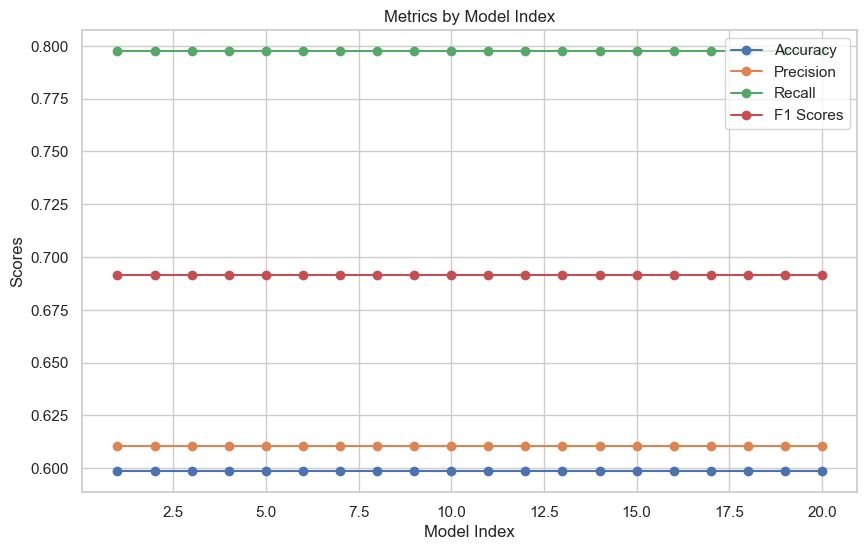

([0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285,
  0.5985714285714285],
 [0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697,
  0.6104651162790697],
 [0.7974683544303798,
  0.7974683544303798,
  0.7974683544303798,
  0.7974683544303798,
  0.7974683544303798,
  0.7974

In [450]:
def predict_indsex_metrics(best_models, model_index, elsa, index_numbers):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    confusion_matrices = []

    for index_number in index_numbers:
        U = generate_U_dataframe(best_models, model_index, elsa)

        # Define the features (independent variables) and the target (dependent variable)
        factor_columns = [col for col in U.columns if col.startswith('Factor')] + ["age"]
        X = U[factor_columns]
        y = elsa["indsex"] - 1  # Convert [1, 2] to [0, 1]

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and fit the logistic regression model
        logistic_model = LogisticRegression()
        logistic_model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = logistic_model.predict(X_test)

        # Calculate classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

    # Plot accuracy and precision scores by model index
    plt.figure(figsize=(10, 6))
    plt.plot(index_numbers, accuracy_scores, marker='o', label='Accuracy')
    plt.plot(index_numbers, precision_scores, marker='o', label='Precision')
    plt.plot(index_numbers, recall_scores, marker='o', label='Recall')
    plt.plot(index_numbers, f1_scores, marker='o', label='F1 Scores')
    plt.xlabel('Model Index')
    plt.ylabel('Scores')
    plt.title('Metrics by Model Index')
    plt.legend()
    plt.grid(True)
    plt.show()

    return accuracy_scores, precision_scores, recall_scores, f1_scores, confusion_matrices


predict_indsex_metrics(best_models, model_index, elsa, index_numbers)


In [455]:
U = generate_U_dataframe(best_models, 3, elsa)
U


Factor1   Factor2   Factor3  age  indsex   frailty  reccare  casp19
0     0.006693  0.007276  0.145767   73       1  0.017241      0.0    35.0
1     0.112331  0.007379  0.463178   82       2  0.068966      0.0    43.0
2     0.007354  0.007320  0.289494   81       2  0.034483      0.0    36.0
3     0.006693  0.007228  0.008419   68       2  0.000000      0.0    56.0
4     0.006693  0.007305  0.369728   71       1  0.034483      1.0    36.0
...        ...       ...       ...  ...     ...       ...      ...     ...
3492  0.006693  0.009070  0.085535   65       2  0.034483      0.0    45.0
3493  0.897881  0.051830  0.118081   70       1  0.206897      0.0    50.0
3494  0.993307  0.007626  0.016435   65       2  0.189655      0.0    40.0
3495  0.159909  0.007547  0.363461   71       1  0.086207      0.0    48.0
3496  0.006693  0.008347  0.488353   65       2  0.068966      0.0    48.0

[3497 rows x 8 columns]

In [484]:
from sklearn.cluster import KMeans

factor_columns = [col for col in U.columns if col.startswith('Factor')]
df = U[factor_columns]
df = df.values
X = np.random.rand(100, 2)

K = 3

kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(X)
#labels = kmeans.labels_

#cluster_centers = kmeans.cluster_centers_

#plt.scatter(X[:, 0], X[:, 1], c=labels)
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red')
#plt.show()

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [492]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(X)
kmeans.labels_

AttributeError: 'NoneType' object has no attribute 'split'

In [490]:
from threadpoolctl import threadpool_info
from pprint import pprint
pprint(threadpool_info())

AttributeError: 'NoneType' object has no attribute 'split'